Data sources:<br>
- https://github.com/BlankerL/DXY-COVID-19-Data
- https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports

References:<br>
- http://datav.aliyun.com/tools/atlas/#&lat=33.50475906922609&lng=104.32617187499999&zoom=4
- https://stackoverflow.com/questions/55106744/how-do-you-convert-shapely-multipolygon-to-polygon
- https://stackoverflow.com/questions/52812231/print-variable-in-jupyter-notebook-markdown-cell-python
- https://matplotlib.org/3.1.0/gallery/color/color_cycler.html#sphx-glr-gallery-color-color-cycler-py
- https://stackoverflow.com/questions/36104016/pandas-pivot-with-rows-and-columns-in-a-given-order

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter

import geopandas
import folium
import branca.colormap as cm
from branca.element import Template, MacroElement

In [2]:
# mac os
font_path = '/Library/Fonts/simhei.ttf'
fontP = font_manager.FontProperties(fname=font_path)
fontP.set_size(14)

fontP_medium = font_manager.FontProperties(fname=font_path)
fontP_medium.set_size(13)

fontP_small = font_manager.FontProperties(fname=font_path)
fontP_small.set_size(11)

In [3]:
data_df = pd.read_csv('DXYArea.csv')
data_supplement = pd.read_csv('DXYArea_supplement.csv')
data_df = data_df[data_df['provinceName'] != '西藏自治区']
data_df = pd.concat([data_df, data_supplement]).reset_index(drop=True)
pop18_df = pd.read_excel('population_2018.xlsx')

china_gdf = geopandas.read_file('china_geo.json', driver='JSON')
province_gdf = geopandas.read_file('province_geo.json', driver='JSON')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [4]:
data_df['updateTime'] = data_df.updateTime.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))
data_df['Date_ymd'] = data_df['updateTime'].apply(lambda d: d.date())
data_df['Time_hms'] = data_df['updateTime'].apply(lambda d: d.time())
# data_df['Date_ymd'] = data_df.updateTime.apply(lambda d: d.strftime('%Y-%m-%d'))
# data_df['Time_hms'] = data_df.updateTime.apply(lambda d: d.strftime('%H:%M:%S'))

data_df = data_df.sort_values(by='updateTime')
data_df = data_df.reset_index(drop=True)

## Data cleaning

In [5]:
# 澳门特别行政区
data_df.loc[data_df['provinceName']=='澳门', 'provinceName'] = '澳门特别行政区'

# 上海市
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='嘉定'), 'cityName'] = '嘉定区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='奉贤'), 'cityName'] = '奉贤区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='宝山'), 'cityName'] = '宝山区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='徐汇'), 'cityName'] = '徐汇区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='杨浦'), 'cityName'] = '杨浦区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='松江'), 'cityName'] = '松江区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='虹口'), 'cityName'] = '虹口区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='金山'), 'cityName'] = '金山区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='长宁'), 'cityName'] = '长宁区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='闵行'), 'cityName'] = '闵行区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='青浦'), 'cityName'] = '青浦区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='静安'), 'cityName'] = '静安区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName']=='黄浦'), 'cityName'] = '黄浦区'
data_df.loc[(data_df['provinceName']=='上海市') & (data_df['cityName'].isin(['浦东', '浦东区'])), 'cityName'] = '浦东新区'

# 云南省
data_df.loc[(data_df['provinceName']=='云南省') & (data_df['cityName']=='丽江市'), 'cityName'] = '丽江'
data_df.loc[(data_df['provinceName']=='云南省') & (data_df['cityName']=='西双版纳州'), 'cityName'] = '西双版纳'

# 内蒙古自治区
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='乌海'), 'cityName'] = '乌海市'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='通辽市经济开发区'), 'cityName'] = '通辽'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='呼和浩特（新城区）'), 'cityName'] = '呼和浩特'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName']=='兴安盟乌兰浩特'), 'cityName'] = '兴安盟'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['包头市东河区', '包头市昆都仑区'])), 'cityName'] = '包头'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['赤峰市松山区', '赤峰市林西县'])), 'cityName'] = '赤峰'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['鄂尔多斯东胜区', '鄂尔多斯鄂托克前旗'])), 'cityName'] = '鄂尔多斯'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['锡林郭勒', '锡林郭勒盟二连浩特', '锡林郭勒盟锡林浩特'])), 'cityName'] = '锡林郭勒盟'
data_df.loc[(data_df['provinceName']=='内蒙古自治区') & (data_df['cityName'].isin(['满洲里', '呼伦贝尔满洲里', '呼伦贝尔牙克石', '呼伦贝尔牙克石市'])), 'cityName'] = '呼伦贝尔'

# 北京市
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='东城'), 'cityName'] = '东城区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='丰台'), 'cityName'] = '丰台区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='大兴'), 'cityName'] = '大兴区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='怀柔'), 'cityName'] = '怀柔区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='昌平'), 'cityName'] = '昌平区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='朝阳'), 'cityName'] = '朝阳区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='海淀'), 'cityName'] = '海淀区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='西城'), 'cityName'] = '西城区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='顺义'), 'cityName'] = '顺义区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='通州'), 'cityName'] = '通州区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='石景山'), 'cityName'] = '石景山区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='门头沟'), 'cityName'] = '门头沟区'
data_df.loc[(data_df['provinceName']=='北京市') & (data_df['cityName']=='武汉来京人员'), 'cityName'] = '外地来京人员'

# 吉林省
data_df.loc[(data_df['provinceName']=='吉林省') & (data_df['cityName']=='吉林'), 'cityName'] = '吉林市'
data_df.loc[(data_df['provinceName']=='吉林省') & (data_df['cityName']=='四平市'), 'cityName'] = '四平'

# 四川省
data_df.loc[(data_df['provinceName']=='四川省') & (data_df['cityName']=='凉山'), 'cityName'] = '凉山州'

# 天津市
data_df.loc[(data_df['provinceName']=='天津市') & (data_df['cityName']=='宁河'), 'cityName'] = '宁河区'
data_df.loc[(data_df['provinceName']=='天津市') & (data_df['cityName']=='外地来津'), 'cityName'] = '外地来津人员'

# 宁夏回族自治区
data_df.loc[(data_df['provinceName']=='宁夏回族自治区') & (data_df['cityName']=='宁东'), 'cityName'] = '宁东管委会'

# 安徽省
data_df.loc[(data_df['provinceName']=='安徽省') & (data_df['cityName']=='歙县'), 'cityName'] = '黄山'
data_df.loc[(data_df['provinceName']=='安徽省') & (data_df['cityName']=='宿松'), 'cityName'] = '安庆'

# 山东省
data_df.loc[(data_df['provinceName']=='山东省') & (data_df['cityName']=='淄博市'), 'cityName'] = '淄博'

# 山西省
data_df.loc[(data_df['provinceName']=='山西省') & (data_df['cityName']=='临汾市'), 'cityName'] = '临汾'
data_df.loc[(data_df['provinceName']=='山西省') & (data_df['cityName']=='朔州市'), 'cityName'] = '朔州'

# 广东省
data_df.loc[(data_df['provinceName']=='广东省') & (data_df['cityName']=='河源市'), 'cityName'] = '河源'
data_df.loc[(data_df['provinceName']=='广东省') & (data_df['cityName']=='外地来穗人员'), 'cityName'] = '外地来粤人员'

# 新疆维吾尔自治区
data_df.loc[(data_df['provinceName']=='新疆维吾尔自治区') & (data_df['cityName']=='吐鲁番市'), 'cityName'] = '吐鲁番'
data_df.loc[(data_df['provinceName']=='新疆维吾尔自治区') &
            (data_df['cityName'].isin(['第七师', '第九师', '第八师', '第八师石河子', '第八师石河子市', '第六师'])),
            'cityName'] = '石河子'

# 江苏省
data_df.loc[(data_df['provinceName']=='江苏省') & (data_df['cityName']=='待明确'), 'cityName'] = '待明确地区'

# 河北省
data_df.loc[(data_df['provinceName']=='河北省') & (data_df['cityName']=='邯郸市'), 'cityName'] = '邯郸'

# 河南省
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='巩义'), 'cityName'] = '邓州'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='固始县'), 'cityName'] = '信阳'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='漯河市'), 'cityName'] = '漯河'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName']=='鹤壁市'), 'cityName'] = '鹤壁'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['南阳（含邓州）', '邓州'])), 'cityName'] = '南阳'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['商丘（含永城）', '永城'])), 'cityName'] = '商丘'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['新乡（含长垣）', '长垣', '长垣县'])), 'cityName'] = '新乡'
data_df.loc[(data_df['provinceName']=='河南省') & (data_df['cityName'].isin(['安阳市', '安阳（含滑县）', '滑县'])), 'cityName'] = '安阳'

# 海南省
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='东方市'), 'cityName'] = '东方'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='临高县'), 'cityName'] = '临高'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='澄迈县'), 'cityName'] = '澄迈'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='琼中县'), 'cityName'] = '琼中'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='琼海市'), 'cityName'] = '琼海'
data_df.loc[(data_df['provinceName']=='海南省') & (data_df['cityName']=='陵水县'), 'cityName'] = '陵水'

# 湖北省
data_df.loc[(data_df['provinceName']=='湖北省') & (data_df['cityName']=='恩施'), 'cityName'] = '恩施州'

# 甘肃省
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='天水市'), 'cityName'] = '天水'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='平凉市'), 'cityName'] = '平凉'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='白银市'), 'cityName'] = '白银'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']=='金昌市'), 'cityName'] = '金昌'
data_df.loc[(data_df['provinceName']=='甘肃省') & (data_df['cityName']==''), 'cityName'] = ''

# 重庆市
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='丰都'), 'cityName'] = '丰都县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='云阳'), 'cityName'] = '云阳县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='垫江'), 'cityName'] = '垫江县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='城口'), 'cityName'] = '城口县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='奉节'), 'cityName'] = '奉节县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='巫山'), 'cityName'] = '巫山县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='巫溪'), 'cityName'] = '巫溪县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='石柱'), 'cityName'] = '石柱县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='秀山'), 'cityName'] = '秀山县'
data_df.loc[(data_df['provinceName']=='重庆市') & (data_df['cityName']=='酉阳县'), 'cityName'] = '酉阳'

# 青海省
data_df.loc[(data_df['provinceName']=='青海省') & (data_df['cityName']=='西宁市'), 'cityName'] = '西宁'
data_df.loc[(data_df['provinceName']=='青海省') & (data_df['cityName']=='北海州'), 'cityName'] = '海北州'


In [6]:
# http://www.gxzf.gov.cn/mlgx/gxrw/qhrk/20170331-486083.shtml
pop18_df.loc[len(pop18_df), 'provinceName'] = '广西壮族自治区'
pop18_df.loc[pop18_df['provinceName'] == '广西壮族自治区', 'population_2018'] = 56590000

pop18_df.loc[len(pop18_df), 'provinceName'] = '宁夏回族自治区'
pop18_df.loc[pop18_df['provinceName'] == '宁夏回族自治区', 'population_2018'] = 56881100

In [7]:
province_daily_last = data_df.groupby(['provinceName', 'Date_ymd'])['Time_hms'].max().reset_index()

for i, cols in province_daily_last.iterrows():
    province_daily_last.loc[i, 'province_confirmedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_confirmedCount'].unique()[0]
    province_daily_last.loc[i, 'province_suspectedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_suspectedCount'].unique()[0]
    province_daily_last.loc[i, 'province_curedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_curedCount'].unique()[0]
    province_daily_last.loc[i, 'province_deadCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                                    (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                                    (data_df['Time_hms'] == cols['Time_hms'])]['province_deadCount'].unique()[0]

province_daily_last = province_daily_last.sort_values(by=['provinceName', 'Date_ymd'])
province_daily_last = province_daily_last.reset_index(drop=True)

In [8]:
city_daily_last = data_df.groupby(['provinceName', 'cityName', 'Date_ymd'])['Time_hms'].max().reset_index()

for i, cols in city_daily_last.iterrows():
    city_daily_last.loc[i, 'city_confirmedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                            (data_df['cityName'] == cols['cityName']) &
                                                            (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                            (data_df['Time_hms'] == cols['Time_hms'])]['city_confirmedCount'].values[0]
    city_daily_last.loc[i, 'city_suspectedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                            (data_df['cityName'] == cols['cityName']) &
                                                            (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                            (data_df['Time_hms'] == cols['Time_hms'])]['city_suspectedCount'].values[0]
    city_daily_last.loc[i, 'city_curedCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                        (data_df['cityName'] == cols['cityName']) &
                                                        (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                        (data_df['Time_hms'] == cols['Time_hms'])]['city_curedCount'].values[0]
    city_daily_last.loc[i, 'city_deadCount'] = data_df[(data_df['provinceName'] == cols['provinceName']) &
                                                       (data_df['cityName'] == cols['cityName']) &
                                                       (data_df['Date_ymd'] == cols['Date_ymd']) &
                                                       (data_df['Time_hms'] == cols['Time_hms'])]['city_deadCount'].values[0]
    
city_daily_last['pcName'] = city_daily_last['provinceName'] + '-' + city_daily_last['cityName']


## Whole China

### Data preparation

In [9]:
def calcul_percentage(numerator, denominator):
    if denominator == 0:
        return numerator * 100
    else:
        return numerator/denominator * 100

In [10]:
# Daily confirmed count per province (complet missing dates)
province_daily_cfirmed_pvt = pd.pivot_table(data=province_daily_last,
                                            index='Date_ymd',
                                            columns='provinceName',
                                            values='province_confirmedCount',
                                            fill_value=0)
province_daily_cfirmed_pvt = province_daily_cfirmed_pvt.reset_index()

for i, v in province_daily_cfirmed_pvt.iterrows():
    for col in province_daily_cfirmed_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            province_daily_cfirmed_pvt.loc[i, col] = province_daily_cfirmed_pvt.loc[i-1, col]

province_daily_cfirmed_pvt.index = province_daily_cfirmed_pvt.Date_ymd

province_daily_cfirmed_df = province_daily_cfirmed_pvt.stack()
province_daily_cfirmed_df = province_daily_cfirmed_df.to_frame().reset_index()
province_daily_cfirmed_df = province_daily_cfirmed_df[
    province_daily_cfirmed_df['provinceName'] != 'Date_ymd'].reset_index(drop=True)

province_daily_cfirmed_df.columns = ['Date_ymd', 'provinceName', 'province_confirmedCount']

In [11]:
# Daily cured count per province (complet missing dates)
province_daily_cured_pvt = pd.pivot_table(data=province_daily_last,
                                          index='Date_ymd',
                                          columns='provinceName',
                                       values='province_curedCount',
                                       fill_value=0)
province_daily_cured_pvt = province_daily_cured_pvt.reset_index()

for i, v in province_daily_cured_pvt.iterrows():
    for col in province_daily_cured_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            province_daily_cured_pvt.loc[i, col] = province_daily_cured_pvt.loc[i-1, col]

province_daily_cured_pvt.index = province_daily_cured_pvt.Date_ymd

province_daily_cured_df = province_daily_cured_pvt.stack()
province_daily_cured_df = province_daily_cured_df.to_frame().reset_index()
province_daily_cured_df = province_daily_cured_df[
    province_daily_cured_df['provinceName'] != 'Date_ymd'].reset_index(drop=True)

province_daily_cured_df.columns = ['Date_ymd', 'provinceName', 'province_curedCount']

In [12]:
# Daily dead count per province (complet missing dates)
province_daily_dead_pvt = pd.pivot_table(data=province_daily_last,
                                      index='Date_ymd',
                                      columns='provinceName',
                                      values='province_deadCount',
                                      fill_value=0)
province_daily_dead_pvt = province_daily_dead_pvt.reset_index()

for i, v in province_daily_dead_pvt.iterrows():
    for col in province_daily_dead_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            province_daily_dead_pvt.loc[i, col] = province_daily_dead_pvt.loc[i-1, col]

province_daily_dead_pvt.index = province_daily_dead_pvt.Date_ymd

province_daily_dead_df = province_daily_dead_pvt.stack()
province_daily_dead_df = province_daily_dead_df.to_frame().reset_index()
province_daily_dead_df = province_daily_dead_df[
    province_daily_dead_df['provinceName'] != 'Date_ymd'].reset_index(drop=True)

province_daily_dead_df.columns = ['Date_ymd', 'provinceName', 'province_deadCount']

In [13]:
province_daily_df = pd.merge(province_daily_cfirmed_df,
                             province_daily_cured_df,
                             on=['Date_ymd', 'provinceName'])
province_daily_df = pd.merge(province_daily_df,
                             province_daily_dead_df,
                             on=['Date_ymd', 'provinceName'])

In [14]:
china_daily_last = province_daily_df.groupby(['Date_ymd'])['province_confirmedCount',
                                                           'province_curedCount',
                                                           'province_deadCount'].sum()
# china_daily_last.index = pd.to_datetime(china_daily_last.index, format='%Y-%m-%d')

china_daily_last['mortality_pct'] = china_daily_last.apply(lambda row:calcul_percentage(
    row['province_deadCount'], row['province_confirmedCount']), axis='columns')

china_daily_last['cured_pct'] = china_daily_last.apply(lambda row:calcul_percentage(
    row['province_curedCount'], row['province_confirmedCount']), axis='columns')

# china_daily_last['mortality_pct'] = \
# china_daily_last['province_deadCount'] / china_daily_last['province_confirmedCount'] * 100
# china_daily_last['cured_pct'] = \
# china_daily_last['province_curedCount'] / china_daily_last['province_confirmedCount'] * 100

china_daily_last['province_confirmedCount_new'] = china_daily_last['province_confirmedCount'].diff()
china_daily_last['province_confirmedCount_deltaRate'] = \
china_daily_last['province_confirmedCount_new'].pct_change() * 100
china_daily_last['province_act_confirmedCount'] = \
china_daily_last['province_confirmedCount'] - china_daily_last['province_curedCount'] - china_daily_last['province_deadCount']
china_daily_last = china_daily_last.fillna(0)

### Confirmed count

In [15]:
DATESFMT = mdates.DateFormatter('%Y-%m-%d')

In [16]:
def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def thousands_1dec(x, pos):
    return '%1.1f' % (x * 1e-3)

def millions(x, pos):
    return '%1.0f' % (x * 1e-6)

formatter_thousands = FuncFormatter(thousands)
formatter_thousands_1dec = FuncFormatter(thousands_1dec)
formatter_millions = FuncFormatter(millions)

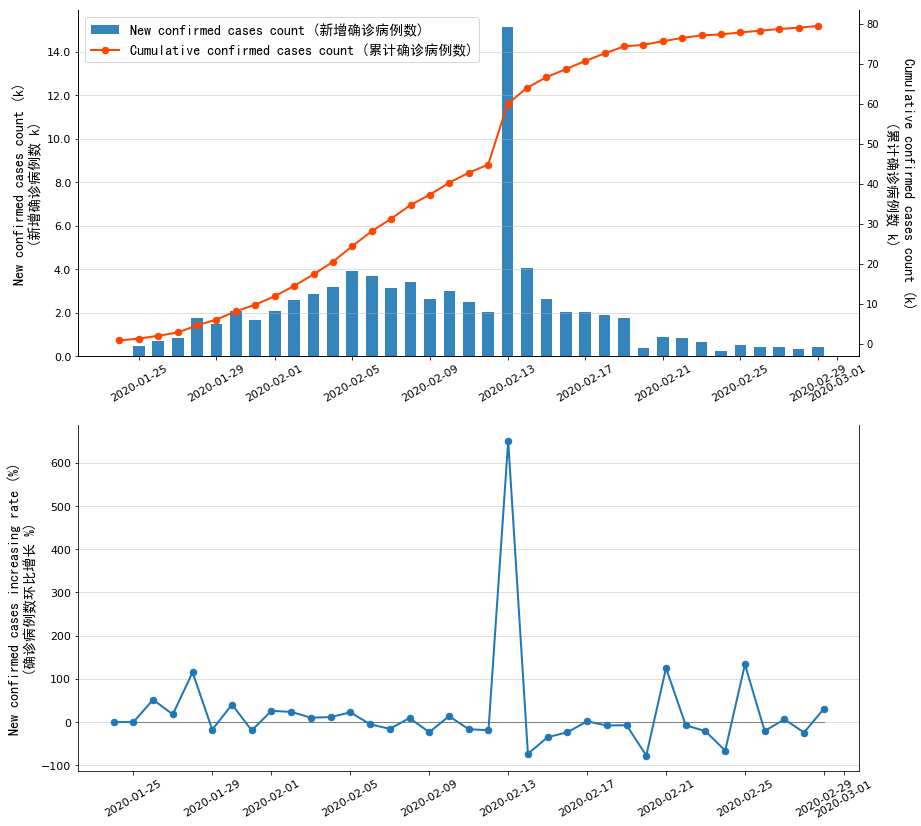

In [86]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

# above
bar_new_cfirmed = ax[0].bar(china_daily_last.index,
                            china_daily_last['province_confirmedCount_new'],
                            alpha=0.9,
                            width=0.6)

ax[0].tick_params(labelsize=11)
ax[0].set_xticklabels(china_daily_last.index, rotation=30)
ax[0].set_ylabel('New confirmed cases count (k)\n(新增确诊病例数 k)', size=12, fontproperties=fontP)
ax[0].yaxis.set_major_formatter(formatter_thousands_1dec)
ax[0].grid(axis='y', which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax_02 = ax[0].twinx()
line_cfirmed, = ax_02.plot(china_daily_last.index,
                           china_daily_last['province_confirmedCount'],
                           color='orangered',
                           linewidth=2,
                           marker='.',
                           markersize=13)
# ax_02.set_xticks(china_daily_last.index)
ax_02.set_xticklabels(china_daily_last.index)
ax_02.set_ylabel('Cumulative confirmed cases count (k)\n(累计确诊病例数 k)', rotation=270,
                 labelpad=35, size=12, fontproperties=fontP)

ax_02.xaxis.set_major_formatter(DATESFMT)
ax_02.yaxis.set_major_formatter(formatter_thousands)

ax_02.legend(handles=(bar_new_cfirmed, line_cfirmed),
             fontsize=13,
             prop=fontP,
             labels=('New confirmed cases count (新增确诊病例数)',
                     'Cumulative confirmed cases count (累计确诊病例数)'),
             loc=2)
ax_02.spines['top'].set_visible(False)

# below
ax[1].plot(china_daily_last.index,
           [0] * len(china_daily_last),
           color='gray', linewidth=1)
line_delta, = ax[1].plot(china_daily_last.index,
                         china_daily_last['province_confirmedCount_deltaRate'],
                         linewidth=2,
                         marker='.',
                         markersize=13)

ax[1].tick_params(labelsize=11)
# ax[1].set_xticks(china_daily_last.index)
ax[1].set_xticklabels(china_daily_last.index, rotation=30)
ax[1].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)


plt.show()

截至北京时间{{china_daily_last.index[-1].year}}年{{china_daily_last.index[-1].month}}月{{china_daily_last.index[-1].day}}日24时，中国累计确诊新冠肺炎病例约{{china_daily_last.loc[china_daily_last.index[-1], 'province_confirmedCount']}}例，较前一天增长{{int(china_daily_last.loc[china_daily_last.index[-1], 'province_confirmedCount_new'])}}例。需要注意的是，2020年2月5日的新增确诊病例量达到顶峰，如果按7-14天潜伏期来算，说明在1月24日与1月29日之间，感染新冠并处于潜伏期的人偏多。此时正值中国新年假期，人们走亲访友可能成为被传染的一个因素。但随后每日新增确诊人数开始下降，环比确诊数也下降到+/-20%，可以反映出1月底人们防范意识开始加强，降低了被传染的可能性。

2020年2月13日，由于湖北省诊断标准更改，新增确诊数大大增加。按原有诊断标准，疑似病例且进行核酸/基因测序检查结果为阳性者被视为新增确诊病例；更改后的诊断标准添加了临床诊断病例，所谓临床诊断病例，是指疑似病例具有肺炎影像学特征者，也就是说，只要符合疑似标准，且有CT特征，即可被视为新增确诊病例，不再需要进行核酸检测。

2020年2月21日，三省五个监狱发现疫情：武汉女子监狱（武汉）确诊230例，湖北省未成年犯管教（武汉）所疑似1例，沙洋汉津监狱（荆门）确诊41例，疑似9例，任城监狱（济宁）确诊200例，疑似10例，十里丰监狱（衢州）确诊34例。监狱系统确诊病例爆发，原因可能是一下三个方面：一、前期防控不足，对密切接触者、疑似人员没有做到“早发现、早隔离、早治疗”；二、在封闭的环境中更容易造成疾病的大范围传播；三、在相关人员（如狱警）确诊后，监狱马上开展了集中的大范围排查，一次性确诊了较多病例。(https://mama.dxy.com/outbreak/daily-of-nationwide-new?index=20200221&locationIds=999&from=todh5)

### Cured count vs. Dead count

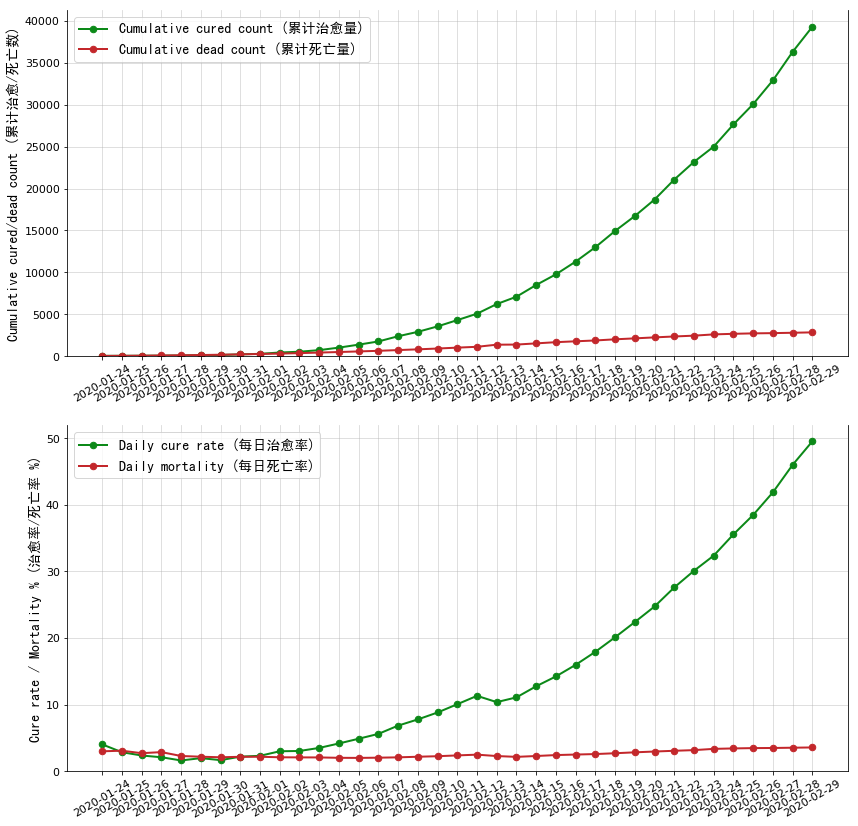

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

line_cured, = ax[0].plot(china_daily_last.index,
                      china_daily_last['province_curedCount'],
                      color='#0c8918', # green
                      linewidth=2,
                      marker='.',
                      markersize=13)

line_dead, = ax[0].plot(china_daily_last.index,
                     china_daily_last['province_deadCount'],
                     color='#c3272b', # red
                     linewidth=2,
                     marker='.',
                     markersize=13)

ax[0].tick_params(labelsize=11)
ax[0].set_xticks(china_daily_last.index)
ax[0].set_xticklabels(china_daily_last.index, rotation=30)
ax[0].set_ylim(bottom=0)
ax[0].set_ylabel('Cumulative cured/dead count (累计治愈/死亡数)', size=12, fontproperties=fontP)

ax[0].xaxis.set_major_formatter(DATESFMT)
ax[0].grid(which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax[0].legend(handles=(line_cured, line_dead),
             fontsize=13,
             prop=fontP,
             labels=('Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=2)

line_cure_rate, = ax[1].plot(china_daily_last.index,
                                 china_daily_last['cured_pct'],
                                 color='#0c8918',
                                 linewidth=2,
                                 marker='.',
                                 markersize=13)
line_mortality_pct, = ax[1].plot(china_daily_last.index,
                                 china_daily_last['mortality_pct'],
                                 color='#c3272b',
                                 linewidth=2,
                                 marker='.',
                                 markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xticks(china_daily_last.index)
ax[1].set_xticklabels(china_daily_last.index, rotation=30)
ax[1].set_ylim(bottom=0)
ax[1].set_ylabel('Cure rate / Mortality % (治愈率/死亡率 %)', size=12, fontproperties=fontP)

ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)

ax[1].legend(handles=(line_cure_rate, line_mortality_pct),
             fontsize=13,
             prop=fontP,
             labels=('Daily cure rate (每日治愈率)',
                     'Daily mortality (每日死亡率)'), loc=2)

plt.show()

截至北京时间{{china_daily_last.index[-1].year}}年{{china_daily_last.index[-1].month}}月{{china_daily_last.index[-1].day}}日24时，中国累计治愈新冠肺炎病例{{china_daily_last.loc[china_daily_last.index[-1], 'province_curedCount']}}例，累计死亡新冠肺炎病例{{china_daily_last.loc[china_daily_last.index[-1], 'province_deadCount']}}例。自2020年1月31日起，中国新冠肺炎病例治愈数量和治愈率超过死亡数量和死亡率，且差值越来越大，目前已达到{{round(china_daily_last.loc[china_daily_last.index[-1], 'cured_pct'], 2)}}%。这和医务人员的不懈努力是分不开的。

## Per province

### Actual confirmed count

In [19]:
province_last_df = province_daily_df[province_daily_df['Date_ymd'] == province_daily_df['Date_ymd'].max()]
province_last_df = province_last_df.reset_index(drop=True)
province_last_df['province_act_confirmedCount'] = \
province_last_df['province_confirmedCount'] - province_last_df['province_curedCount'] - province_last_df['province_deadCount']

In [20]:
province_last_geo = pd.merge(province_last_df,
                             province_gdf[['name', 'geometry']],
                             left_on='provinceName',
                             right_on='name')
province_last_geo = province_last_geo.drop(columns='name')
province_last_geo = province_last_geo.dropna()

In [21]:
crs = {'init': 'epsg:4326'}
province_last_gdf = geopandas.GeoDataFrame(province_last_geo, crs=crs)

In [22]:
template_province = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body> 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:16px; right: 20px; top: 20px;'>
     
<div class='legend-title'>Confirmed count<br>(确诊数量)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#fdeed5;opacity:1;'></span>1 - 9</li>
    <li><span style='background:#f6a88e;opacity:1;'></span>10 - 99</li>
    <li><span style='background:#e86558;opacity:1;'></span>100 - 499</li>
    <li><span style='background:#d13035;opacity:1;'></span>500 - 999</li>
    <li><span style='background:#8c1f28;opacity:1;'></span>1000 - 10000</li>
    <li><span style='background:#59060a;opacity:1;'></span>> 10000</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [23]:
template_province_title = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:25px; left: 60px; top: 0px;'>
<div class='legend-title'>Confirmed count per province (各省/直辖市/自治区确诊数量)</div>
<div class='legend-scale'><font size="3">China (中国) / Per province (各省/直辖市/自治区) / 2020-02-29</font></div>
</div>

</body>
</html>

{% endmacro %}"""

In [24]:
province_map = folium.Map(location=[36.130926, 106.925774],
                          zoom_start=4, tiles='cartodbpositron')

colormap_province = cm.StepColormap(
    colors=['#fdeed5', '#f6a88e', '#e86558',
            '#d13035', '#8c1f28', '#59060a'],
    vmin=min(province_last_gdf['province_act_confirmedCount']),
    vmax=max(province_last_gdf['province_act_confirmedCount']),
    index=[1, 9, 99, 499, 999, 10000, 100000000])

style_function = lambda x: {
    'fillColor': colormap_province(x['properties']['province_act_confirmedCount']),
    'color': '',
    'weight': 0.0001,
    'fillOpacity': 1
}

folium.GeoJson(
    province_last_gdf[province_last_gdf['province_act_confirmedCount']>0][['provinceName', 'province_act_confirmedCount', 'geometry']],
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
            fields=['provinceName', 'province_act_confirmedCount'],
            aliases=['Province', 'Actual confirmed count'],
            localize=False
        ),
    name='confirmed').add_to(province_map)

folium.GeoJson(
    province_last_gdf[province_last_gdf['province_act_confirmedCount']==0][['provinceName', 'province_act_confirmedCount', 'geometry']],
    style_function = lambda x: {
        'color': 'white',
        'fillOpacity': 1
    },
    tooltip=folium.GeoJsonTooltip(
            fields=['provinceName', 'province_act_confirmedCount'],
            aliases=['Province', 'Actual confirmed count'],
            localize=False
        ),
    name='confirmed').add_to(province_map)

folium.GeoJson(
    province_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
    },
    name='Province').add_to(province_map)

folium.GeoJson(
    china_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
    },
    name='China').add_to(province_map)

macro = MacroElement()
macro._template = Template(template_province)
macro2 = MacroElement()
macro2._template = Template(template_province_title)
province_map.get_root().add_child(macro)
province_map.get_root().add_child(macro2)


### Map in time series

In [25]:
province_daily_ts = province_daily_df.copy()

province_daily_ts['province_act_confirmedCount'] = \
province_daily_ts['province_confirmedCount'] - province_daily_ts['province_curedCount'] - province_daily_ts['province_deadCount']
province_daily_ts = province_daily_ts.fillna(0)
province_daily_ts = province_daily_ts.sort_values(['provinceName', 'Date_ymd']).reset_index(drop=True)

province_daily_ts_geo = pd.merge(province_daily_ts,
                                 province_gdf[['name', 'geometry']],
                                 left_on='provinceName',
                                 right_on='name',
                                 how='left')
province_daily_ts_geo = province_daily_ts_geo[['provinceName', 'geometry']]
province_daily_ts_geo = province_daily_ts_geo.drop_duplicates('provinceName').reset_index(drop=True)


In [26]:
datetime_index = pd.DatetimeIndex(province_daily_ts.Date_ymd.unique())

dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = np.array(dt_index_epochs).astype('U10')

In [27]:
styledata = {}

s = 0
e = province_daily_ts.Date_ymd.nunique()
for i, v in province_daily_ts_geo.iterrows():
    df = pd.DataFrame(
        {'color': np.array(province_daily_ts.province_act_confirmedCount[s:e]),
         'opacity': np.array([1] * province_daily_ts.Date_ymd.nunique())},
        index=dt_index
    )
    styledata[i] = df
    s += province_daily_ts.Date_ymd.nunique()
    e += province_daily_ts.Date_ymd.nunique()

In [28]:
max_opacity, min_opacity = 1, 1

colormap_province = cm.StepColormap(
    colors=['#ffffff', '#fdeed5', '#f6a88e', '#e86558',
            '#d13035', '#8c1f28', '#59060a'],
    vmin=min(province_last_gdf['province_act_confirmedCount']),
    vmax=max(province_last_gdf['province_act_confirmedCount']),
    index=[0, 0.9, 9, 99, 499, 999, 10000, 100000000])

for i, data in styledata.items():
    data['color'] = data['color'].map(colormap_province)
    data['opacity'] = 1

In [29]:
styledict = {
    str(nb): data.to_dict(orient='index') for nb, data in styledata.items()
}

In [30]:
template_choropleth = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body> 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:16px; right: 20px; top: 90px;'>
     
<div class='legend-title'>Confirmed count<br>(确诊数量)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#fdeed5;opacity:1;'></span>1 - 9</li>
    <li><span style='background:#f6a88e;opacity:1;'></span>10 - 99</li>
    <li><span style='background:#e86558;opacity:1;'></span>100 - 499</li>
    <li><span style='background:#d13035;opacity:1;'></span>500 - 999</li>
    <li><span style='background:#8c1f28;opacity:1;'></span>1000 - 10000</li>
    <li><span style='background:#59060a;opacity:1;'></span>> 10000</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""



In [31]:
crs = {'init': 'epsg:4326'}
province_daily_ts_gdf = geopandas.GeoDataFrame(province_daily_ts_geo, crs=crs)

from folium.plugins import TimeSliderChoropleth

province_actual_confirmed_history_map = folium.Map(location=[36.130926, 106.925774],
                                                   zoom_start = 4, tiles='cartodbpositron')

TimeSliderChoropleth(
    province_daily_ts_gdf.to_json(),
    styledict=styledict
).add_to(province_actual_confirmed_history_map)

folium.GeoJson(
    province_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0
    },
    name='Province').add_to(province_actual_confirmed_history_map)

folium.GeoJson(
    china_gdf,
    style_function = lambda x: {
        'color': 'black',
        'weight': 2.5,
        'fillOpacity': 0
    },
    name='China').add_to(province_actual_confirmed_history_map)

macro = MacroElement()
macro._template = Template(template_choropleth)
province_actual_confirmed_history_map.get_root().add_child(macro)

province_actual_confirmed_history_map

In [32]:
province_actual_confirmed_history_map.save('province_actual_confirmed_history_map.html')

### Hubei vs. other provinces

In [33]:
province_last_sorted_df = province_last_df.copy()
province_last_sorted_df = province_last_sorted_df.sort_values(by='province_act_confirmedCount',
                                                              ascending=False).reset_index(drop=True)

**Cumulative confirmed count (Hubei vs. other provinces)**

In [34]:
hubei_last_sorted_df = province_last_sorted_df[
    province_last_sorted_df['provinceName'] == '湖北省'].reset_index(drop=True)

not_hubei_last_sorted_df = province_last_sorted_df[
    province_last_sorted_df['provinceName'] != '湖北省'].reset_index(drop=True)
not_hubei_last_tot = not_hubei_last_sorted_df.groupby(['Date_ymd'])['province_act_confirmedCount',
                                                                    'province_curedCount',
                                                                    'province_deadCount'].sum().reset_index()
not_hubei_last_tot.insert(loc=1, column='provinceName', value='非湖北省')

hubei_vs_others_last_df = pd.concat([hubei_last_sorted_df, not_hubei_last_tot])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [35]:
# Hubei vs others: confirmed count, cured rate & mortality
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_confirmedCount'] = \
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_act_confirmedCount'] + \
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_curedCount'] + \
hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName']=='非湖北省', 'province_deadCount']

hubei_vs_others_last_df['cured_pct'] = \
hubei_vs_others_last_df['province_curedCount'] / hubei_vs_others_last_df['province_confirmedCount']
hubei_vs_others_last_df['mortality_pct'] = \
hubei_vs_others_last_df['province_deadCount'] / hubei_vs_others_last_df['province_confirmedCount']

In [36]:
# Not Hubei: cured rate & mortality
not_hubei_last_sorted_df['cured_pct'] = \
not_hubei_last_sorted_df['province_curedCount'] / not_hubei_last_sorted_df['province_confirmedCount']
not_hubei_last_sorted_df['mortality_pct'] = \
not_hubei_last_sorted_df['province_deadCount'] / not_hubei_last_sorted_df['province_confirmedCount']

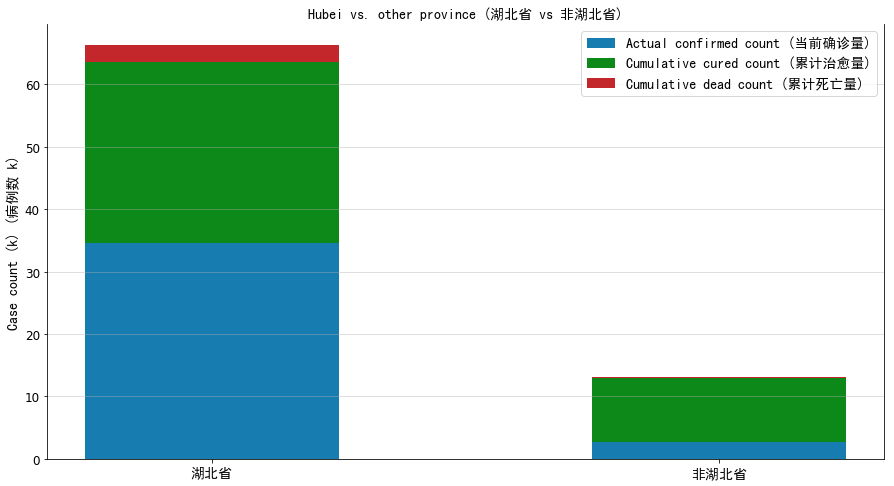

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

# Hubei vs. other province
ax.set_title('Hubei vs. other province (湖北省 vs 非湖北省)', fontdict={'fontsize': 14}, fontproperties=fontP)
rect01 = ax.bar(hubei_vs_others_last_df.provinceName,
                   hubei_vs_others_last_df.province_act_confirmedCount,
                   color='#177cb0',
                   width=0.5)
rect02 = ax.bar(hubei_vs_others_last_df.provinceName,
                   hubei_vs_others_last_df.province_curedCount,
                   bottom=hubei_vs_others_last_df.province_act_confirmedCount,
                   color='#0c8918',
                   width=0.5)
rect03 = ax.bar(hubei_vs_others_last_df.provinceName,
                   hubei_vs_others_last_df.province_deadCount,
                   bottom=hubei_vs_others_last_df.province_act_confirmedCount + hubei_vs_others_last_df.province_curedCount,
                   color='#c3272b',
                   width=0.5)

ax.tick_params(labelsize=12)
ax.set_xticklabels(hubei_vs_others_last_df.provinceName, fontproperties=fontP)
ax.set_ylabel('Case count (k) (病例数 k)', size=12, fontproperties=fontP)
ax.yaxis.set_major_formatter(formatter_thousands)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', which='major', alpha=0.5)

ax.legend(handles=(rect01, rect02, rect03),
             fontsize=12,
             prop=fontP,
             labels=('Actual confirmed count (当前确诊量)',
                     'Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=1)

plt.show()

截至北京时间{{china_daily_last.index[-1].year}}年{{china_daily_last.index[-1].month}}月{{china_daily_last.index[-1].day}}日24时，中国各省（直辖市、自治区）中湖北省确诊病例最多，累计高达{{hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'province_confirmedCount'][0]}}例，远超其余省份确诊数量之和（{{hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'province_confirmedCount'][0]}}）；湖北省治愈率为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'cured_pct'][0] * 100, 1)}}%，其余省份为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'cured_pct'][0] * 100, 1)}}%；湖北省新冠肺炎死亡率为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '湖北省', 'mortality_pct'][0] * 100, 1)}}%，其余省份为{{round(hubei_vs_others_last_df.loc[hubei_vs_others_last_df['provinceName'] == '非湖北省', 'mortality_pct'][0] * 100, 1)}}%。



In [38]:
hubei_vs_others_last_df

Date_ymd provinceName province_act_confirmedCount  \
0  2020-02-29          湖北省                       34617   
0  2020-02-29         非湖北省                        2629   

  province_confirmedCount province_curedCount province_deadCount cured_pct  \
0                   66337               28993               2727  0.437056   
0                   13058               10318                111  0.790167   

  mortality_pct  
0     0.0411083  
0    0.00850054

**Cumulative confirmed count per province (not Hubei)**

In [39]:
pop_sorted_cfirmedCnt = pd.merge(province_last_sorted_df[['provinceName']], pop18_df,
                                 on='provinceName', how='left')

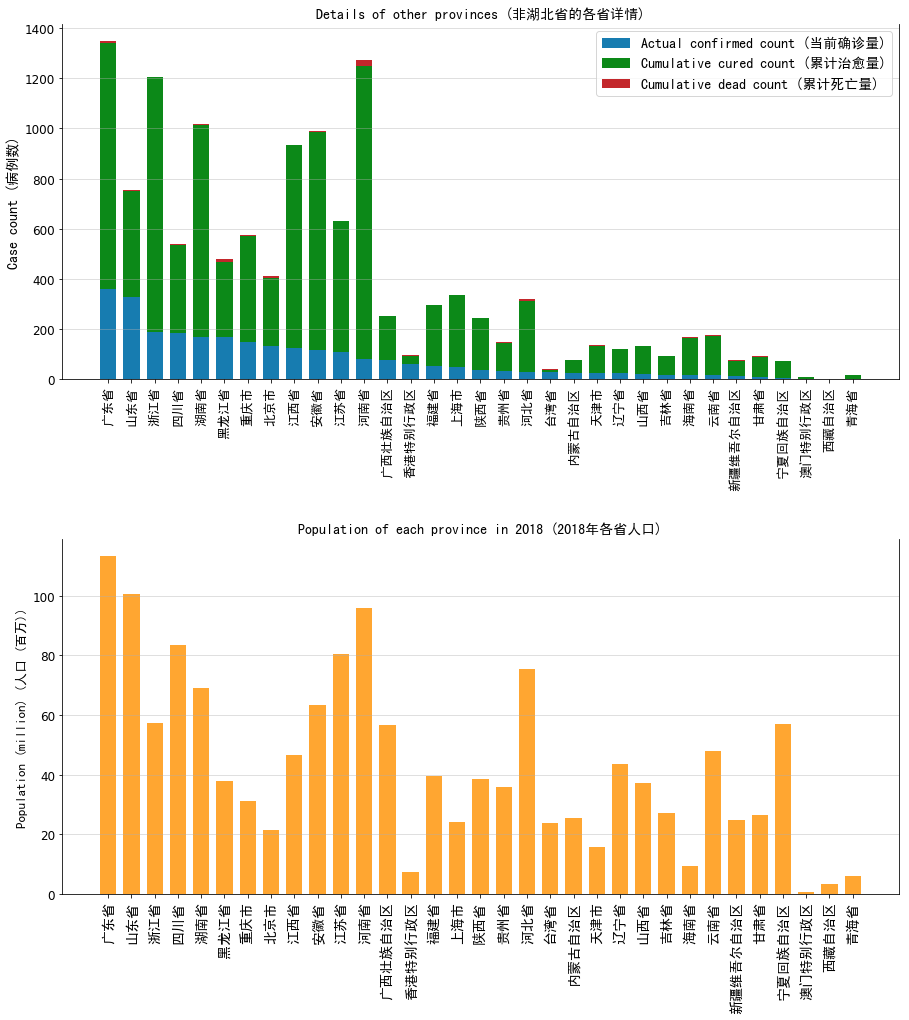

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Details of other provinces
ax[0].set_title('Details of other provinces (非湖北省的各省详情)', fontdict={'fontsize': 14}, fontproperties=fontP)
rect11 = ax[0].bar(not_hubei_last_sorted_df.provinceName,
                   not_hubei_last_sorted_df.province_act_confirmedCount,
                   color='#177cb0',
                   width=0.7)
rect12 = ax[0].bar(not_hubei_last_sorted_df.provinceName,
                   not_hubei_last_sorted_df.province_curedCount,
                   bottom=not_hubei_last_sorted_df.province_act_confirmedCount,
                   color='#0c8918',
                   width=0.7)
rect13 = ax[0].bar(not_hubei_last_sorted_df.provinceName,
                   not_hubei_last_sorted_df.province_deadCount,
                   bottom=not_hubei_last_sorted_df.province_act_confirmedCount + not_hubei_last_sorted_df.province_curedCount,
                   color='#c3272b',
                   width=0.7)

ax[0].tick_params(labelsize=12)
ax[0].set_xticklabels(not_hubei_last_sorted_df.provinceName, rotation=90, fontproperties=fontP_medium)
ax[0].set_ylabel('Case count (病例数)', fontproperties=fontP)
ax[0].spines['top'].set_visible(False)
ax[0].grid(axis='y', which='major', alpha=0.5)

ax[0].legend(handles=(rect11, rect12, rect13),
             prop=fontP,
             labels=('Actual confirmed count (当前确诊量)',
                     'Cumulative cured count (累计治愈量)',
                     'Cumulative dead count (累计死亡量)'), loc=1)

# Population of each province
ax[1].set_title('Population of each province in 2018 (2018年各省人口)',
                fontdict={'fontsize': 14}, fontproperties=fontP)
ax[1].bar(pop_sorted_cfirmedCnt[pop_sorted_cfirmedCnt['provinceName']!='湖北省'].provinceName,
          pop_sorted_cfirmedCnt[pop_sorted_cfirmedCnt['provinceName']!='湖北省'].population_2018,
          color='#ffa631',
          width=0.7)

ax[1].tick_params(labelsize=12)
ax[1].set_xticklabels(pop_sorted_cfirmedCnt[pop_sorted_cfirmedCnt['provinceName']!='湖北省'].provinceName,
                      rotation=90, fontproperties=fontP)
ax[1].set_ylabel('Population (million) (人口 (百万))', size=12, fontproperties=fontP_medium)
ax[1].spines['top'].set_visible(False)
ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].yaxis.set_major_formatter(formatter_millions)

plt.subplots_adjust(hspace=0.45)
plt.show()

上图省份按照现存确诊数降序排列。除湖北省，广东省、河南省和浙江省，累计确诊均多于1000例，对照2018年人口数据，人口多、人员流动性强也许是其中一个原因；西藏自治区于2020年1月29日出现1例确诊，且该患者已于2月12日被治愈出院；2月21日10时20分，青海省最后2例新冠肺炎病例从青海省第四人民医院出院 。至此，青海收住在青海省第四人民医院的15例确诊病例全部出院，加之前期收住在西宁市第三人民医院已经出院的3例确诊病例，青海18例确诊病例全部出院。西藏自治区和青海省目前为中国唯一两个零确诊病例的省（直辖市、自治区）。

https://m.weibo.cn/status/4474349975557803?

**Cured rate & mortality (not Hubei)**

In [41]:
# Each province: cured rate & mortality
province_last_sorted_df['cured_pct'] = \
province_last_sorted_df['province_curedCount'] / province_last_sorted_df['province_confirmedCount'] *100
province_last_sorted_df['mortality_pct'] = \
province_last_sorted_df['province_deadCount'] / province_last_sorted_df['province_confirmedCount'] * 100

province_last_sorted_df['province_confirmedCount'] = province_last_sorted_df['province_confirmedCount'].astype(int)
province_last_sorted_df['province_curedCount'] = province_last_sorted_df['province_curedCount'].astype(int)
province_last_sorted_df['province_deadCount'] = province_last_sorted_df['province_deadCount'].astype(int)
province_last_sorted_df['cured_pct'] = province_last_sorted_df['cured_pct'].astype(float)
province_last_sorted_df['mortality_pct'] = province_last_sorted_df['mortality_pct'].astype(float)

In [42]:
province_colors = ['#9d2933', '#c83c23', '#be002f', '#ff2121', '#db5a6b', '#ff7500', '#ff8936',
                   '#ffa631', '#fff143', '#eaff56', '#f0c239', '#d9b611', '#bce672', '#afdd22',
                   '#00bc12', '#0c8918', '#40de5a', '#00e079', '#3de1ad', '#48c0a3', '#70f3ff',
                   '#44cef6', '#177cb0', '#065279', '#4b5cc4', '#8d4bbb', '#815463', '#b0a4e3',
                   '#cca4e3', '#edd1d8', '#88ada6', '#f3d3e7', '#d4f2e7', '#eedeb0']

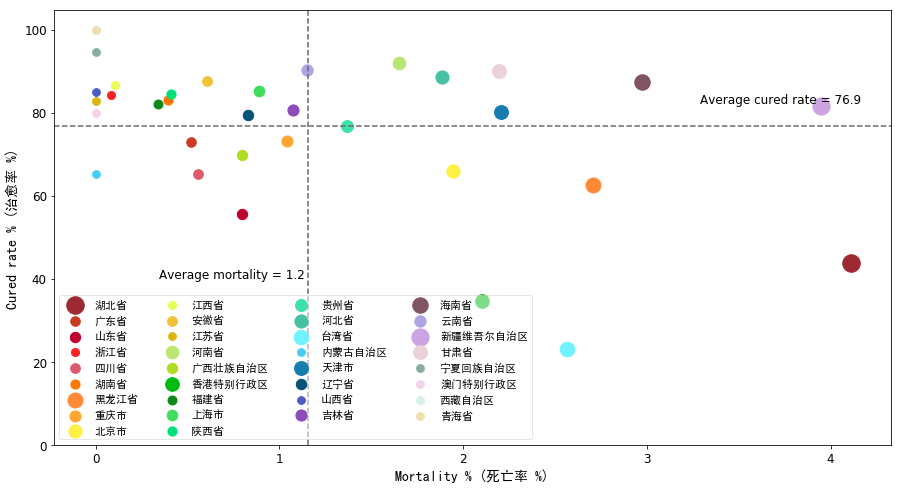

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.set_prop_cycle(color=province_colors)
for i, rows in province_last_sorted_df.iterrows():
    ax.scatter(x=rows['mortality_pct'],
               y=rows['cured_pct'],
               s=(rows['mortality_pct']+1)*60,
               label=rows['provinceName'])

ax.tick_params(labelsize=12)
ax.set_xlabel('Mortality % (死亡率 %)', fontproperties=fontP)
ax.set_ylabel('Cured rate % (治愈率 %)', fontproperties=fontP)
ax.set_ylim(bottom=0)
ax.legend(ncol=4, prop=fontP_small, framealpha=0.5)

ax.axhline(province_last_sorted_df['cured_pct'].mean(), color='dimgray', linestyle='--')
ax.axvline(province_last_sorted_df['mortality_pct'].mean(), color='dimgray', linestyle='--')

ax.text(x=province_last_sorted_df['mortality_pct'].max() * 0.8,
        y=province_last_sorted_df['cured_pct'].mean() * 1.07,
        s='Average cured rate = {:.1f}'.format(province_last_sorted_df['cured_pct'].mean()),
        fontsize=12)
ax.text(x=province_last_sorted_df['mortality_pct'].mean() * 0.3,
        y=40,
        s='Average mortality = {:.1f}'.format(province_last_sorted_df['mortality_pct'].mean()),
        fontsize=12)

plt.show()

由于湖北省是最早出现病例且爆发的省份，医疗设备紧缺，导致湖北省的死亡率在所有省份中很高；除此之外，黑龙江省新冠肺炎的死亡率也很高，由丁香园2月8日的日报得知，黑龙江省死亡率高的原因主要有以下两点：人民警惕性偏低和家庭聚集。东北三省，发现第一例病例均为1月22日，且都为外地返乡人员，且三省均在1月25日启动了重大突发公共卫生事件I级响应，然而对比三省人民对这次疫情的态度，我们发现黑龙江人民相对警惕性偏低；截止2月6日，黑龙江家庭聚集占比93.75%，48起因“聚集”引发的肺炎，有45起都是因为“家庭聚集”，其中黑龙江死亡病例的3人均因“家庭聚集”。

其次，有几个省份的治愈率达到了50%，西藏自治区累计确诊1例且治愈，故治愈率为100%；青海省累计确诊{{province_last_sorted_df[province_last_sorted_df['provinceName']=='青海省']['province_confirmedCount'].values[0]}}例且已全部治愈，故治愈率为100%；甘肃省累计确诊病例也偏少（{{province_last_sorted_df[province_last_sorted_df['provinceName']=='甘肃省']['province_confirmedCount'].values[0]}}例），所以相对来说治愈率高；澳门特别行政区，同理。

很不幸，2020年2月16日，台湾省出现首例新冠肺炎死亡病例，使得累计确诊有{{province_last_sorted_df[province_last_sorted_df['provinceName']=='台湾省']['province_confirmedCount'].values[0]}}例的台湾省的死亡率达到{{round(province_last_sorted_df[province_last_sorted_df['provinceName']=='台湾省']['mortality_pct'].values[0], 1)}}%。

https://mama.dxy.com/outbreak/daily-of-nationwide-new?index=20200208&locationIds=999&from=Previous_Review

In [44]:
province_last_sorted_df[province_last_sorted_df['cured_pct']>=50]

Date_ymd provinceName  province_confirmedCount  province_curedCount  \
1   2020-02-29          广东省                     1349                  983   
2   2020-02-29          山东省                      756                  421   
3   2020-02-29          浙江省                     1205                 1016   
4   2020-02-29          四川省                      538                  351   
5   2020-02-29          湖南省                     1018                  846   
6   2020-02-29         黑龙江省                      480                  301   
7   2020-02-29          重庆市                      576                  422   
8   2020-02-29          北京市                      411                  271   
9   2020-02-29          江西省                      935                  811   
10  2020-02-29          安徽省                      990                  868   
11  2020-02-29          江苏省                      631                  523   
12  2020-02-29          河南省                     1272                 1170   
13  2020-02-29      广西壮族自治区                      252                  176   
15  2020-02-29          福建省                      296                  243   
16  2020-02-29          上海市                      337                  287   
17  2020-02-29          陕西省                      245                  207   
18  2020-02-29          贵州省                      146                  112   
19  2020-02-29          河北省                      318                  282   
21  2020-02-29       内蒙古自治区                       75                   49   
22  2020-02-29          天津市                      136                  109   
23  2020-02-29          辽宁省                      121                   96   
24  2020-02-29          山西省                      133                  113   
25  2020-02-29          吉林省                       93                   75   
26  2020-02-29          海南省                      168                  147   
27  2020-02-29          云南省                      174                  157   
28  2020-02-29     新疆维吾尔自治区                       76                   62   
29  2020-02-29          甘肃省                       91                   82   
30  2020-02-29      宁夏回族自治区                       73                   69   
31  2020-02-29      澳门特别行政区                       10                    8   
32  2020-02-29        西藏自治区                        1                    1   
33  2020-02-29          青海省                       18                   18   

    province_deadCount province_act_confirmedCount   cured_pct  mortality_pct  
1                    7                         359   72.868792       0.518903  
2                    6                         329   55.687831       0.793651  
3                    1                         188   84.315353       0.082988  
4                    3                         184   65.241636       0.557621  
5                    4                         168   83.104126       0.392927  
6                   13                         166   62.708333       2.708333  
7                    6                         148   73.263889       1.041667  
8                    8                         132   65.936740       1.946472  
9                    1                         123   86.737968       0.106952  
10                   6                         116   87.676768       0.606061  
11                   0                         108   82.884311       0.000000  
12                  21                          81   91.981132       1.650943  
13                   2                          74   69.841270       0.793651  
15                   1                          52   82.094595       0.337838  
16                   3                          47   85.163205       0.890208  
17                   1                          37   84.489796       0.408163  
18                   2                          32   76.712329       1.369863  
19                   6                          30   88.679245       1.886792  
21                   

**Daily new confirmed count & daily cumulative confirmed count (not Hubei)**

In [45]:
not_hubei_daily_df = province_daily_df[province_daily_df['provinceName'] != '湖北省']
not_hubei_daily_df = not_hubei_daily_df.groupby(['Date_ymd'])['province_confirmedCount',
                                                              'province_curedCount',
                                                              'province_deadCount'].sum()

not_hubei_daily_df.index = pd.to_datetime(china_daily_last.index, format='%Y-%m-%d')

not_hubei_daily_df['mortality_pct'] = \
not_hubei_daily_df['province_deadCount'] / not_hubei_daily_df['province_confirmedCount'] * 100
not_hubei_daily_df['cured_pct'] = \
not_hubei_daily_df['province_curedCount'] / not_hubei_daily_df['province_confirmedCount'] * 100

not_hubei_daily_df['province_confirmedCount_new'] = not_hubei_daily_df['province_confirmedCount'].diff()
not_hubei_daily_df['province_confirmedCount_deltaRate'] = \
not_hubei_daily_df['province_confirmedCount_new'].pct_change() * 100
not_hubei_daily_df['province_act_confirmedCount'] = \
not_hubei_daily_df['province_confirmedCount'] - not_hubei_daily_df['province_curedCount'] - not_hubei_daily_df['province_deadCount']
not_hubei_daily_df = not_hubei_daily_df.fillna(0)

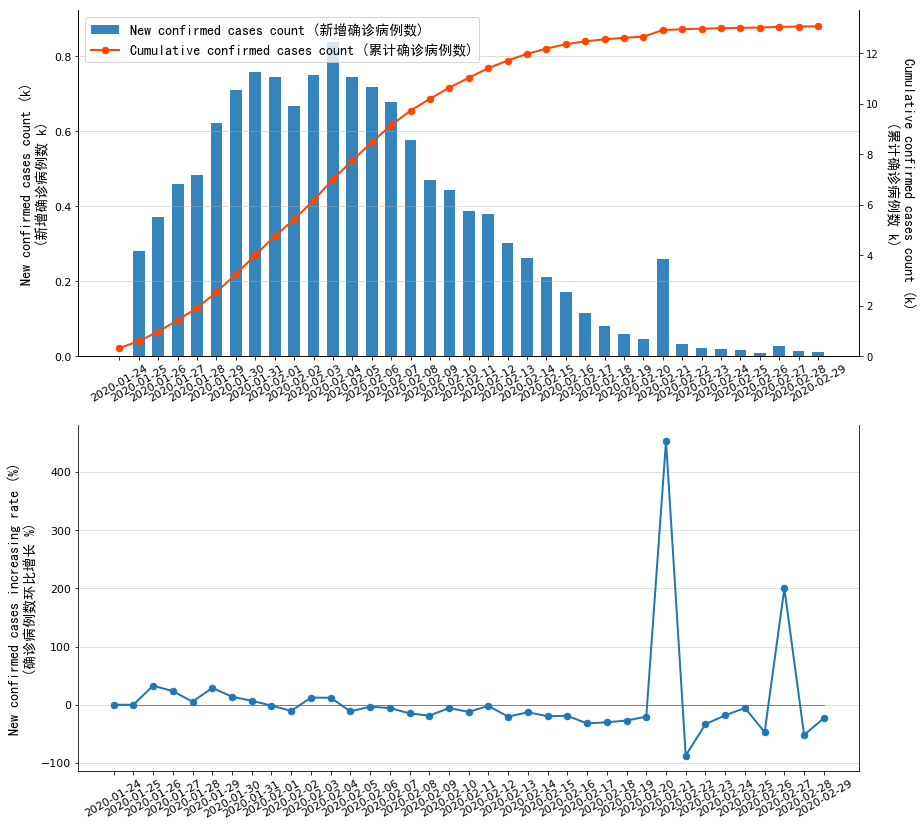

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

# above
bar_new_cfirmed = ax[0].bar(not_hubei_daily_df.index,
                            not_hubei_daily_df['province_confirmedCount_new'],
                            alpha=0.9,
                            width=0.6)

ax[0].tick_params(labelsize=11)
ax[0].set_xticklabels(not_hubei_daily_df.index, rotation=30)
ax[0].set_ylabel('New confirmed cases count (k)\n(新增确诊病例数 k)', size=12, fontproperties=fontP)
ax[0].set_ylim(bottom=0, top=not_hubei_daily_df['province_confirmedCount_new'].max()*1.1)
ax[0].yaxis.set_major_formatter(formatter_thousands_1dec)
ax[0].grid(axis='y', which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax_02 = ax[0].twinx()
line_cfirmed, = ax_02.plot(not_hubei_daily_df.index,
                           not_hubei_daily_df['province_confirmedCount'],
                           color='orangered',
                           linewidth=2,
                           marker='.',
                           markersize=13)
ax_02.set_xticks(not_hubei_daily_df.index)
ax_02.set_xticklabels(not_hubei_daily_df.index, rotation=30)
ax_02.set_ylabel('Cumulative confirmed cases count (k)\n(累计确诊病例数 k)', rotation=270,
                 labelpad=35, size=12, fontproperties=fontP)
ax_02.set_ylim(bottom=0)
ax_02.xaxis.set_major_formatter(DATESFMT)
ax_02.yaxis.set_major_formatter(formatter_thousands)

ax_02.legend(handles=(bar_new_cfirmed, line_cfirmed),
             fontsize=13,
             prop=fontP,
             labels=('New confirmed cases count (新增确诊病例数)',
                     'Cumulative confirmed cases count (累计确诊病例数)'),
             loc=2)
ax_02.spines['top'].set_visible(False)

# below
ax[1].plot(not_hubei_daily_df.index,
           [0] * len(not_hubei_daily_df),
           color='gray', linewidth=1)
line_delta, = ax[1].plot(not_hubei_daily_df.index,
                         not_hubei_daily_df['province_confirmedCount_deltaRate'],
                         linewidth=2,
                         marker='.',
                         markersize=13)

ax[1].tick_params(labelsize=11)
ax[1].set_xticks(not_hubei_daily_df.index)
ax[1].set_xticklabels(not_hubei_daily_df.index, rotation=30)
ax[1].set_ylabel('New confirmed cases increasing rate (%)\n(确诊病例数环比增长 %)', size=12, fontproperties=fontP)
ax[1].xaxis.set_major_formatter(DATESFMT)
ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)


plt.show()

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，除湖北省以外的省份，每日新增确诊病例已从2月5日起连续下降，且从2月14日起，每日新增确诊已低于1月24日水平了，这一天是武汉封城的第二天。

2020年2月21日，三省五个监狱发现疫情，导致新增确诊病例大增：武汉女子监狱（武汉）确诊230例，湖北省未成年犯管教（武汉）所疑似1例，沙洋汉津监狱（荆门）确诊41例，疑似9例，任城监狱（济宁）确诊200例，疑似10例，十里丰监狱（衢州）确诊34例。

**Daily cumulative confirmed count for each province**

In [47]:
province_daily_df['province_confirmedCount'] = province_daily_df['province_confirmedCount'].astype(int)
province_daily_df['province_curedCount'] = province_daily_df['province_curedCount'].astype(int)
province_daily_df['province_deadCount'] = province_daily_df['province_deadCount'].astype(int)

In [48]:
province_daily_cfirmed_pvt = pd.pivot_table(data = province_daily_df,
                                            columns='Date_ymd',
                                            index='provinceName',
                                            values='province_confirmedCount')
province_daily_cfirmed_pvt = province_daily_cfirmed_pvt.sort_values(by=province_daily_cfirmed_pvt.columns[-1],
                                                                    ascending=False)


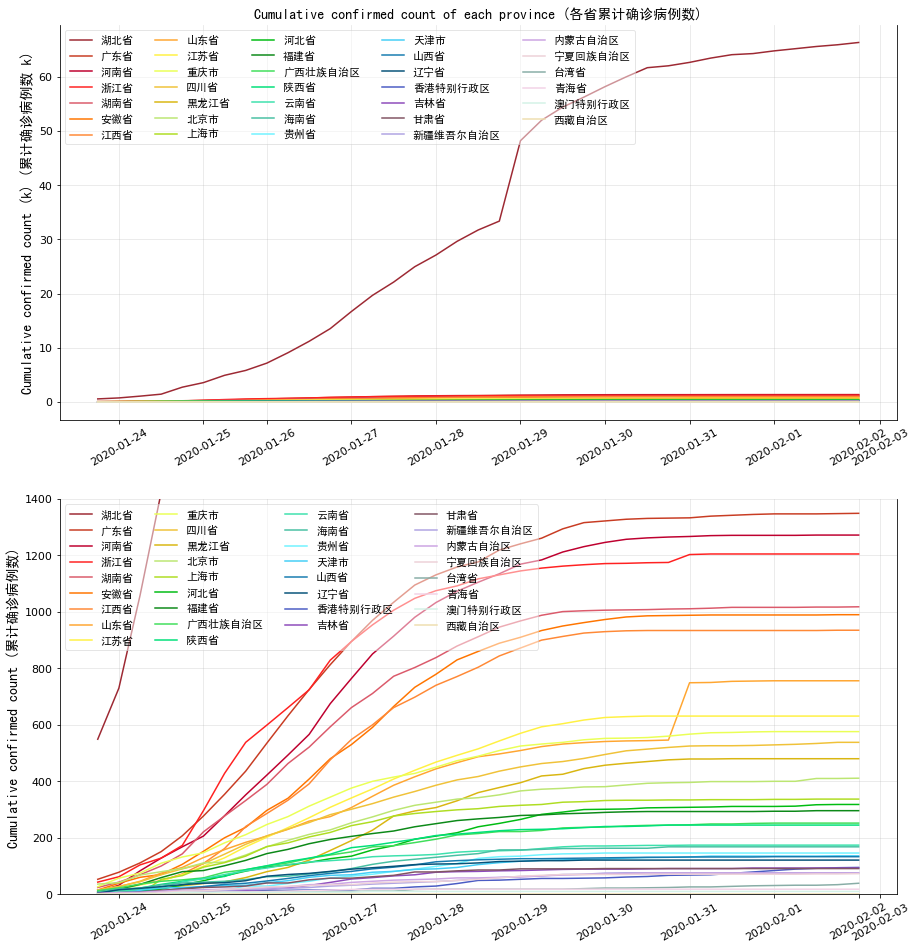

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Cumulative confirmed count of each provinces
ax[0].set_title('Cumulative confirmed count of each province (各省累计确诊病例数)',
                fontdict={'fontsize': 14}, fontproperties=fontP)

ax[0].set_prop_cycle(color=province_colors)
for city, d in province_daily_cfirmed_pvt.iterrows():
    ax[0].plot(d.index, d, label=city)

ax[0].tick_params(labelsize=11)
ax[0].set_xticklabels(province_daily_cfirmed_pvt.columns, rotation=30)
ax[0].set_ylabel('Cumulative confirmed count (k) (累计确诊病例数 k)', fontproperties=fontP)
ax[0].spines['top'].set_visible(False)
ax[0].grid(which='major', alpha=0.3)
ax[0].legend(loc=2, ncol=5, prop=fontP_small, framealpha=0.5)
ax[0].yaxis.set_major_formatter(formatter_thousands)

ax[1].set_prop_cycle(color=province_colors)
for city, d in province_daily_cfirmed_pvt.iterrows():
    ax[1].plot(d.index, d, label=city)

ax[1].tick_params(labelsize=11)
ax[1].set_xticklabels(province_daily_cfirmed_pvt.columns, rotation=30)
ax[1].set_ylabel('Cumulative confirmed count (累计确诊病例数)', fontproperties=fontP)
ax[1].set_ylim(bottom=0, top=1400)
ax[1].spines['top'].set_visible(False)
ax[1].grid(which='major', alpha=0.3)
ax[1].legend(loc=2, ncol=4, prop=fontP_small, framealpha=0.5)

plt.show()

由上图可以看出，湖北省新增确诊病例数从2020年2月4日逐渐放缓，2月13日湖北省诊断标准更改，新增确诊数大大增加，随后新增确诊数量恢复至13日之前的速度。可以体现出与湖北省自身情况相比，已经有好转的迹象，但由于湖北省是新冠肺炎始发省份，最初的确诊病例就多于其他省份，且人们对此病毒的抵抗力偏低，所以导致湖北省的确诊病例远远高于其他省份（直辖市、自治区）。

此外，由下面的图不难看出，我们可以把除湖北省外的省份（直辖市、自治区）分成三组：一、累计确诊高于1100例的三个省份（广东省、河南省和浙江省），二、累计确诊介于900与1100例的三个省份（湖南省、安徽省和江西省），三、其他所有省份（直辖市、自治区）。第一组中起初累计确诊病例最多的省份为广东省，但于1月29日被浙江省反超，后来于2月5日超过浙江省，而浙江省的累计确诊病例数自2月8日起趋于平缓且于2月12日被河南省超过。广东省累计确诊病例多的原因可能跟广东省人口多有关，人口多，基数大，是导致累计确诊数量大的其中一个原因。河南省南临湖北省，地理位置相邻也许是该省累计确诊数量多的其中一个原因；另外，据央视新闻客户端报道，2020年1月23日，河南省许昌市刘某某在疫情期间为其儿子在许昌东城区某大酒店举办婚宴。2月5日，刘某某女儿确诊为新型冠状病毒肺炎病例后，面对疾控部门工作人员的询问，刘某刻意隐瞒其从武汉返乡的事实，也绝口不提家中曾办过婚礼大宴宾客。之后工作人员通过调查，发现婚宴的参与者共有约200人。此类“家庭聚集”事件也是促使新冠病毒传染的一大因素。

2020年2月21日，三省五个监狱发现疫情，导致新增确诊病例大增：武汉女子监狱（武汉）确诊230例，湖北省未成年犯管教（武汉）所疑似1例，沙洋汉津监狱（荆门）确诊41例，疑似9例，任城监狱（济宁）确诊200例，疑似10例，十里丰监狱（衢州）确诊34例。

**Cumulative confirmed count daily evolution**

In [50]:
province_daily_cfirmed_evol = province_daily_cfirmed_pvt.pct_change(axis='columns')
province_daily_cfirmed_evol = province_daily_cfirmed_evol.fillna(0)

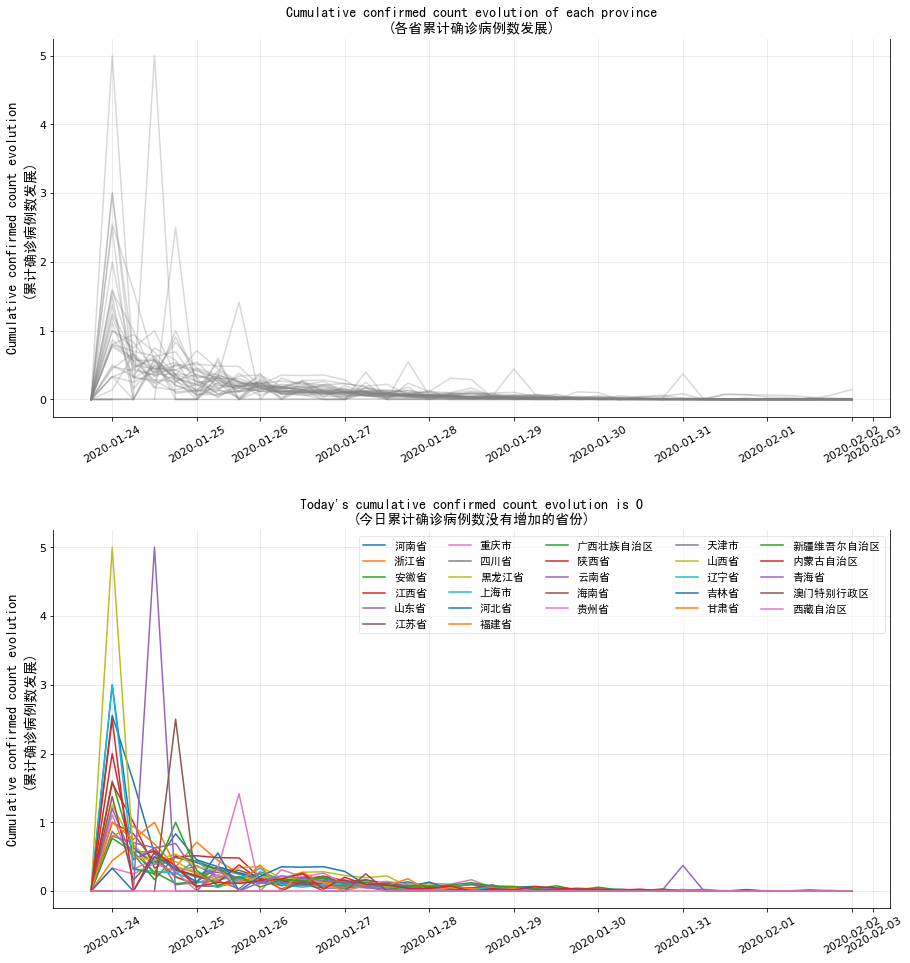

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

# Cumulative confirmed count evolution of each province
ax[0].set_title('Cumulative confirmed count evolution of each province\n(各省累计确诊病例数发展)',
                fontdict={'fontsize': 14}, fontproperties=fontP)

for city, d in province_daily_cfirmed_evol.iterrows():
    ax[0].plot(d.index, d, label=city, alpha=0.3, color='gray')

ax[0].tick_params(labelsize=11)
ax[0].set_xticklabels(province_daily_cfirmed_evol.columns)
ax[0].set_xticklabels(province_daily_cfirmed_evol.columns, rotation=30)
ax[0].set_ylabel('Cumulative confirmed count evolution\n(累计确诊病例数发展)', fontproperties=fontP)
ax[0].spines['top'].set_visible(False)
ax[0].grid(which='major', alpha=0.3)


ax[1].set_title('Today\'s cumulative confirmed count evolution is 0\n(今日累计确诊病例数没有增加的省份)',
             fontdict={'fontsize': 14}, fontproperties=fontP)

last_date = province_daily_cfirmed_evol.columns[-1]
# ax[1].set_prop_cycle(color=province_colors)
for city, d in province_daily_cfirmed_evol[province_daily_cfirmed_evol[last_date]==0].iterrows():
    ax[1].plot(d.index, d, label=city)

ax[1].tick_params(labelsize=11)
ax[1].set_xticklabels(province_daily_cfirmed_evol.columns)
ax[1].set_xticklabels(province_daily_cfirmed_evol.columns, rotation=30)
ax[1].set_ylabel('Cumulative confirmed count evolution\n(累计确诊病例数发展)', fontproperties=fontP)
ax[1].spines['top'].set_visible(False)
ax[1].grid(which='major', alpha=0.3)
ax[1].legend(loc=1, ncol=5, prop=fontP_small, framealpha=0.5)

plt.subplots_adjust(hspace=0.3)
plt.show()

新型冠状肺炎爆发初期，各省（直辖市、自治区）每日新增确诊病例数量多且不稳定，自2月1日起，每日新增确诊病例百分比逐渐趋于平稳。

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，{{len(province_daily_cfirmed_evol[province_daily_cfirmed_evol[last_date]==0])}}个省（直辖市、自治区）较前一日无新增确诊病例，其中西藏自治区自1月29日起无新增确诊病例，青海省和澳门特别行政区自2月7日起无新增确诊病例，台湾省在2月10日于2月15日之间无新增确诊病例。

## Per city

In [52]:
# Daily confirmed count per province (complet missing dates)
city_daily_cfirmed_pvt = pd.pivot_table(data=city_daily_last,
                                        index='Date_ymd',
                                        columns='pcName',
                                        values='city_confirmedCount',
                                        fill_value=0)
city_daily_cfirmed_pvt = city_daily_cfirmed_pvt.reset_index()

for i, v in city_daily_cfirmed_pvt.iterrows():
    for col in city_daily_cfirmed_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            city_daily_cfirmed_pvt.loc[i, col] = city_daily_cfirmed_pvt.loc[i-1, col]

city_daily_cfirmed_pvt.index = city_daily_cfirmed_pvt.Date_ymd

city_daily_cfirmed_df = city_daily_cfirmed_pvt.stack()
city_daily_cfirmed_df = city_daily_cfirmed_df.to_frame().reset_index()
city_daily_cfirmed_df = city_daily_cfirmed_df[
    city_daily_cfirmed_df['pcName'] != 'Date_ymd'].reset_index(drop=True)

city_daily_cfirmed_df.columns = ['Date_ymd', 'pcName', 'city_confirmedCount']

In [53]:
# Daily dead count per province (complet missing dates)
city_daily_cured_pvt = pd.pivot_table(data=city_daily_last,
                                      index='Date_ymd',
                                      columns='pcName',
                                      values='city_curedCount',
                                      fill_value=0)
city_daily_cured_pvt = city_daily_cured_pvt.reset_index()

for i, v in city_daily_cured_pvt.iterrows():
    for col in city_daily_cured_pvt.columns[1:]:
        if i > 0:
            if v[col] == 0:
                city_daily_cured_pvt.loc[i, col] = city_daily_cured_pvt.loc[i-1, col]

city_daily_cured_pvt.index = city_daily_cured_pvt.Date_ymd

city_daily_cured_df = city_daily_cured_pvt.stack()
city_daily_cured_df = city_daily_cured_df.to_frame().reset_index()
city_daily_cured_df = city_daily_cured_df[
    city_daily_cured_df['pcName'] != 'Date_ymd'].reset_index(drop=True)

city_daily_cured_df.columns = ['Date_ymd', 'pcName', 'city_curedCount']

In [54]:
# Daily dead count per province (complet missing dates)
city_daily_dead_pvt = pd.pivot_table(data=city_daily_last,
                                      index='Date_ymd',
                                      columns='pcName',
                                      values='city_deadCount',
                                      fill_value=0)
city_daily_dead_pvt = city_daily_dead_pvt.reset_index()

for i, v in city_daily_dead_pvt.iterrows():
    for col in city_daily_dead_pvt.columns[1:]:
        if i > 0:
            if v[col] == 0:
                city_daily_dead_pvt.loc[i, col] = city_daily_dead_pvt.loc[i-1, col]

city_daily_dead_pvt.index = city_daily_dead_pvt.Date_ymd

city_daily_dead_df = city_daily_dead_pvt.stack()
city_daily_dead_df = city_daily_dead_df.to_frame().reset_index()
city_daily_dead_df = city_daily_dead_df[
    city_daily_dead_df['pcName'] != 'Date_ymd'].reset_index(drop=True)

city_daily_dead_df.columns = ['Date_ymd', 'pcName', 'city_deadCount']

In [55]:
city_daily_df = pd.merge(city_daily_cfirmed_df,
                         city_daily_cured_df,
                         on=['Date_ymd', 'pcName'],
                         how='left')
city_daily_df = pd.merge(city_daily_df,
                         city_daily_dead_df,
                         on=['Date_ymd', 'pcName'],
                         how='left')

### Actual confirmed count

In [56]:
city_last_df = city_daily_df[city_daily_df['Date_ymd'] == city_daily_df['Date_ymd'].max()]
city_last_df = city_last_df.reset_index(drop=True)

city_last_df['city_act_confirmedCount'] = \
city_last_df['city_confirmedCount'] - city_last_df['city_curedCount'] - city_last_df['city_deadCount']
city_last_df = city_last_df[(city_last_df['city_confirmedCount'] > 0) &
                            (city_last_df['city_act_confirmedCount'] >= 0)]

city_last_df['cured_pct'] = \
city_last_df['city_curedCount'] / city_last_df['city_confirmedCount'] * 100
city_last_df['mortality_pct'] = \
city_last_df['city_deadCount'] / city_last_df['city_confirmedCount'] * 100

In [57]:
print('Actual confirmed count Top 10 cities（现有确诊病例数量排名前十的城市）：\n')
city_last_df.sort_values('city_act_confirmedCount', ascending=False).head(10)

Actual confirmed count Top 10 cities（现有确诊病例数量排名前十的城市）：



Date_ymd     pcName city_confirmedCount city_curedCount city_deadCount  \
332  2020-02-29     湖北省-武汉               48557           17636           2169   
327  2020-02-29     湖北省-孝感                3518            2047            115   
341  2020-02-29     湖北省-黄冈                2904            2119            115   
339  2020-02-29     湖北省-鄂州                1390             747             44   
336  2020-02-29     湖北省-荆州                1579             965             46   
340  2020-02-29     湖北省-随州                1307             797             40   
328  2020-02-29     湖北省-宜昌                 931             463             31   
338  2020-02-29     湖北省-襄阳                1175             802             33   
337  2020-02-29     湖北省-荆门                 924             563             37   
329  2020-02-29  湖北省-待明确地区                 312              12              0   

    city_act_confirmedCount cured_pct mortality_pct  
332                   28752   36.3202       4.46692  
327                    1356   58.1865        3.2689  
341                     670   72.9683       3.96006  
339                     599    53.741       3.16547  
336                     568   61.1146       2.91324  
340                     470   60.9793       3.06044  
328                     437   49.7315       3.32975  
338                     340   68.2553       2.80851  
337                     324   60.9307       4.00433  
329                     300   3.84615             0

In [58]:
print('Cities recover 0 actual confirmed case（现存确诊病例为零的城市）：\n')
city_last_df[city_last_df['city_act_confirmedCount'] == 0]

Cities recover 0 actual confirmed case（现存确诊病例为零的城市）：



Date_ymd         pcName city_confirmedCount city_curedCount  \
9    2020-02-29        上海市-杨浦区                   9               9   
14   2020-02-29        上海市-长宁区                  13              13   
19   2020-02-29         云南省-临沧                   1               1   
20   2020-02-29         云南省-丽江                   7               7   
23   2020-02-29        云南省-大理州                  13              13   
28   2020-02-29        云南省-文山州                   2               2   
31   2020-02-29         云南省-普洱                   4               4   
35   2020-02-29        云南省-楚雄州                   4               4   
39   2020-02-29       云南省-西双版纳                  15              14   
41   2020-02-29     内蒙古自治区-乌海市                   2               2   
42   2020-02-29     内蒙古自治区-兴安盟                   1               1   
72   2020-02-29        吉林省-吉林市                   5               5   
74   2020-02-29         吉林省-延边                   5               5   
75   2020-02-29         吉林省-松原                   2               2   
76   2020-02-29        吉林省-梅河口                   1               1   
81   2020-02-29         四川省-乐山                   3               3   
87   2020-02-29         四川省-广元                   6               6   
93   2020-02-29        四川省-攀枝花                  16              16   
98   2020-02-29         四川省-自贡                   9               9   
102  2020-02-29        四川省-阿坝州                   1               1   
104  2020-02-29        天津市-东丽区                   4               4   
108  2020-02-29     天津市-外地来津人员                   6               6   
113  2020-02-29        天津市-武清区                   2               2   
116  2020-02-29        天津市-河西区                   4               4   
118  2020-02-29       天津市-滨海新区                   3               3   
119  2020-02-29        天津市-红桥区                   2               2   
120  2020-02-29        天津市-西青区                   4               4   
123  2020-02-29     宁夏回族自治区-固原                   5               5   
124  2020-02-29  宁夏回族自治区-宁东管委会                   1               1   
126  2020-02-29    宁夏回族自治区-石嘴山                   1               1   
..          ...            ...                 ...             ...   
381  2020-02-29         福建省-龙岩                   6               6   
382  2020-02-29       西藏自治区-拉萨                   1               1   
384  2020-02-29         贵州省-安顺                   4               4   
389  2020-02-29         贵州省-铜仁                  10              10   
390  2020-02-29       贵州省-黔东南州                  10              10   
392  2020-02-29       贵州省-黔西南州                   4               4   
397  2020-02-29         辽宁省-本溪                   3               3   
399  2020-02-29         辽宁省-盘锦                  11              11   
400  2020-02-29         辽宁省-营口                   1               1   
402  2020-02-29         辽宁省-辽阳                   3               3   
405  2020-02-29         辽宁省-阜新                   8               8   
416  2020-02-29        重庆市-城口县                   2               2   
427  2020-02-29        重庆市-梁平区                   4               4   
428  2020-02-29        重庆市-武隆区                   1               1   
429  2020-02-29        重庆市-永川区                   5               5   
431  2020-02-29        重庆市-江津区                   4               4   
437  2020-02-29        重庆市-璧山区                   9               9   
439  2020-02-29        重庆市-秀山县                   1               1   
442  2020-02-29         重庆市-酉阳                   1               1   
445  2020-02-29        重庆市-高新区                   4               4   
446  2020-02-29        重庆市-黔江区                   2               2   
451  2020-02-29         陕西省-延安                   8               8   
453  2020-02-29         陕西省-杨凌                   1               1   
454  2020-02-29         陕西省-榆林                   3               3   
459  2020-02-29         陕西省-韩城                   1               1   
461  2020-02-29  

In [59]:
print('Cured rate Top 10 cities（治愈率排名前十的城市）：\n')
city_last_df.sort_values('cured_pct', ascending=False).head(10)

Cured rate Top 10 cities（治愈率排名前十的城市）：



Date_ymd      pcName city_confirmedCount city_curedCount  \
241  2020-02-29      江苏省-泰州                  37              37   
87   2020-02-29      四川省-广元                   6               6   
102  2020-02-29     四川省-阿坝州                   1               1   
322  2020-02-29      海南省-陵水                   4               4   
390  2020-02-29    贵州省-黔东南州                  10              10   
320  2020-02-29      海南省-琼中                   1               1   
98   2020-02-29      四川省-自贡                   9               9   
392  2020-02-29    贵州省-黔西南州                   4               4   
206  2020-02-29  广西壮族自治区-梧州                   5               5   
314  2020-02-29      海南省-文昌                   3               3   

    city_deadCount city_act_confirmedCount cured_pct mortality_pct  
241              0                       0       100             0  
87               0                       0       100             0  
102              0                       0       100             0  
322              0                       0       100             0  
390              0                       0       100             0  
320              0                       0       100             0  
98               0                       0       100             0  
392              0                       0       100             0  
206              0                       0       100             0  
314              0                       0       100             0

In [60]:
print('Mortality Top 10 cities（死亡率排名前十的城市）：\n')
city_last_df.sort_values('mortality_pct', ascending=False).head(10)

Mortality Top 10 cities（死亡率排名前十的城市）：



Date_ymd              pcName city_confirmedCount city_curedCount  \
312  2020-02-29              海南省-定安                   3               2   
218  2020-02-29      新疆维吾尔自治区-兵团第九师                   4               2   
220  2020-02-29  新疆维吾尔自治区-兵团第八师石河子市                   4               2   
321  2020-02-29              海南省-琼海                   6               5   
313  2020-02-29           海南省-待明确地区                   7               3   
271  2020-02-29             河南省-三门峡                   7               6   
319  2020-02-29              海南省-澄迈                   9               7   
267  2020-02-29             河北省-秦皇岛                  10               9   
223  2020-02-29      新疆维吾尔自治区-兵团第四师                  10               9   
383  2020-02-29             贵州省-六盘水                  10               8   

    city_deadCount city_act_confirmedCount cured_pct mortality_pct  
312              1                       0   66.6667       33.3333  
218              1                       1        50            25  
220              1                       1        50            25  
321              1                       0   83.3333       16.6667  
313              1                       3   42.8571       14.2857  
271              1                       0   85.7143       14.2857  
319              1                       1   77.7778       11.1111  
267              1                       0        90            10  
223              1                       0        90            10  
383              1                       1        80            10

### 六大地理分区

- 华北地区（北京市、天津市、河北省、山西省）<br>
- 东北地区（辽宁省、吉林省、黑龙江省、内蒙古自治区）<br>
- 华东地区（上海市、江苏省、浙江省、安徽省、福建省、江西省、山东省、台湾省）<br>
- 中南地区（河南省、湖北省、湖南省、广东省、广西壮族自治区、海南省、香港特别行政区、澳门特别行政区）<br>
- 西南地区（四川省、贵州省、云南省、重庆市、西藏自治区）<br>
- 西北地区（陕西省、甘肃省、青海省、宁夏回族自治区、新疆维吾尔自治区）<br>

In [61]:
province_region_dict = {'北京市':'华北地区',
                        '河北省':'华北地区',
                        '天津市':'华北地区',
                        '山西省':'华北地区',
                        '辽宁省':'东北地区',
                        '吉林省':'东北地区',
                        '黑龙江省':'东北地区',
                        '内蒙古自治区':'东北地区',
                        '上海市':'华东地区',
                        '安徽省':'华东地区',
                        '山东省':'华东地区',
                        '江苏省':'华东地区',
                        '江西省':'华东地区',
                        '浙江省':'华东地区',
                        '福建省':'华东地区',
                        '台湾省':'华东地区',
                        '广东省':'中南地区',
                        '河南省':'中南地区',
                        '海南省':'中南地区',
                        '湖北省':'中南地区',
                        '湖南省':'中南地区',
                        '广西壮族自治区':'中南地区',
                        '香港特别行政区':'中南地区',
                        '澳门特别行政区':'中南地区',
                        '四川省':'西南地区',
                        '云南省':'西南地区',
                        '贵州省':'西南地区',
                        '重庆市':'西南地区',
                        '西藏自治区':'西南地区',
                        '甘肃省':'西北地区',
                        '陕西省':'西北地区',
                        '青海省':'西北地区',
                        '宁夏回族自治区':'西北地区',
                        '新疆维吾尔自治区':'西北地区'}

In [62]:
provinceCity_last_df = pd.merge(city_last_df,
                                city_daily_last[['pcName', 'provinceName']].drop_duplicates(),
                                on='pcName')

provinceCity_last_df['region'] = provinceCity_last_df['provinceName'].map(province_region_dict)

In [63]:
provinceCity_daily_last_df = pd.merge(city_daily_df,
                                      city_daily_last[['pcName', 'provinceName']].drop_duplicates(),
                                      on='pcName')

provinceCity_daily_last_df['city_act_confirmedCount'] = \
provinceCity_daily_last_df['city_confirmedCount'] - \
provinceCity_daily_last_df['city_curedCount'] - \
provinceCity_daily_last_df['city_deadCount']

provinceCity_daily_last_df = provinceCity_daily_last_df[(provinceCity_daily_last_df['city_confirmedCount'] > 0) &
                            (provinceCity_daily_last_df['city_act_confirmedCount'] >= 0)]

provinceCity_daily_last_df['cured_pct'] = \
provinceCity_daily_last_df['city_curedCount'] / provinceCity_daily_last_df['city_confirmedCount'] * 100
provinceCity_daily_last_df['mortality_pct'] = \
provinceCity_daily_last_df['city_deadCount'] / provinceCity_daily_last_df['city_confirmedCount'] * 100

provinceCity_daily_last_df['region'] = provinceCity_daily_last_df['provinceName'].map(province_region_dict)
provinceCity_daily_last_df['city_confirmedCount'] = provinceCity_daily_last_df['city_confirmedCount'].astype(int)

In [64]:
def region_scatter_line_charts(provinceCity_last_df, provinceCity_daily_last_df, title,
                               region, loc, ncol, bbox_to_anchor, color=province_colors, scale=3):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))

    last_df = provinceCity_last_df[provinceCity_last_df['region'] == region].sort_values(
        'city_confirmedCount', ascending=False)

    label_cities = []
    ax[0].set_title(title, fontdict={'fontsize': 14}, fontproperties=fontP)
    ax[0].set_prop_cycle(color=color)
    for i, rows in last_df.iterrows():
        if rows['mortality_pct'] > 0 or \
        rows['city_confirmedCount'] > last_df['city_confirmedCount'].mean():
            ax[0].scatter(x=rows['city_confirmedCount'],
                          y=rows['mortality_pct'],
                          s=(rows['city_confirmedCount'])*scale,
                          label=rows['pcName'])
            label_cities.append(rows['pcName'])
        else:
            ax[0].scatter(x=rows['city_confirmedCount'],
                          y=rows['mortality_pct'],
                          s=(rows['city_confirmedCount'])*scale)

    ax[0].tick_params(labelsize=12)
    ax[0].set_xlabel('Cumulative confirmed count (累计确诊病例)', fontproperties=fontP)
    ax[0].set_ylabel('Mortality % (死亡率 %)', fontproperties=fontP)
    ax[0].legend(loc=loc, ncol=ncol, prop=fontP_small, framealpha=0.5, bbox_to_anchor=bbox_to_anchor)

    ax[0].axhline(last_df['mortality_pct'].mean(),
                  color='dimgray', linestyle='--')
    ax[0].axvline(last_df['city_confirmedCount'].mean(),
                  color='dimgray', linestyle='--')

    ax[0].text(x=last_df['city_confirmedCount'].max() * 0.8,
               y=last_df['mortality_pct'].mean() * 1.3,
               s='Average mortality = {:.1f}'.format(last_df['mortality_pct'].mean()),
               fontsize=12)
    ax[0].text(x=last_df['city_confirmedCount'].mean() * 0.4,
               y=last_df['mortality_pct'].max() * 0.9,
               s='Average cumulative confirmed count = {:.1f}'.format(last_df['city_confirmedCount'].mean()),
               fontsize=12)

    ax[1].set_prop_cycle(color=province_colors)
    provinceCity_daily_pvt = pd.pivot_table(data=provinceCity_daily_last_df[
        provinceCity_daily_last_df['region']==region],
                                            index='pcName',
                                            columns='Date_ymd',
                                            values='city_confirmedCount',
                                            fill_value=0)
    provinceCity_daily_pvt = provinceCity_daily_pvt.sort_values(by=provinceCity_daily_pvt.columns[-1],
                                                                ascending=False)

    for city, d in provinceCity_daily_pvt.iterrows():
        if city in label_cities:
            ax[1].plot(d.index, d, label=city)

    ax[1].tick_params(labelsize=11)
    ax[1].set_xticklabels(provinceCity_daily_pvt.columns, rotation=30)
    ax[1].set_ylabel('Cumulative confirmed count (累计确诊病例数)', fontproperties=fontP)
    ax[1].spines['top'].set_visible(False)
    ax[1].grid(which='major', alpha=0.3)
    ax[1].legend(loc=2, ncol=3, prop=fontP_small, framealpha=0.5)
    
    return last_df, provinceCity_daily_pvt


**华北地区（北京市、天津市、河北省、山西省）**

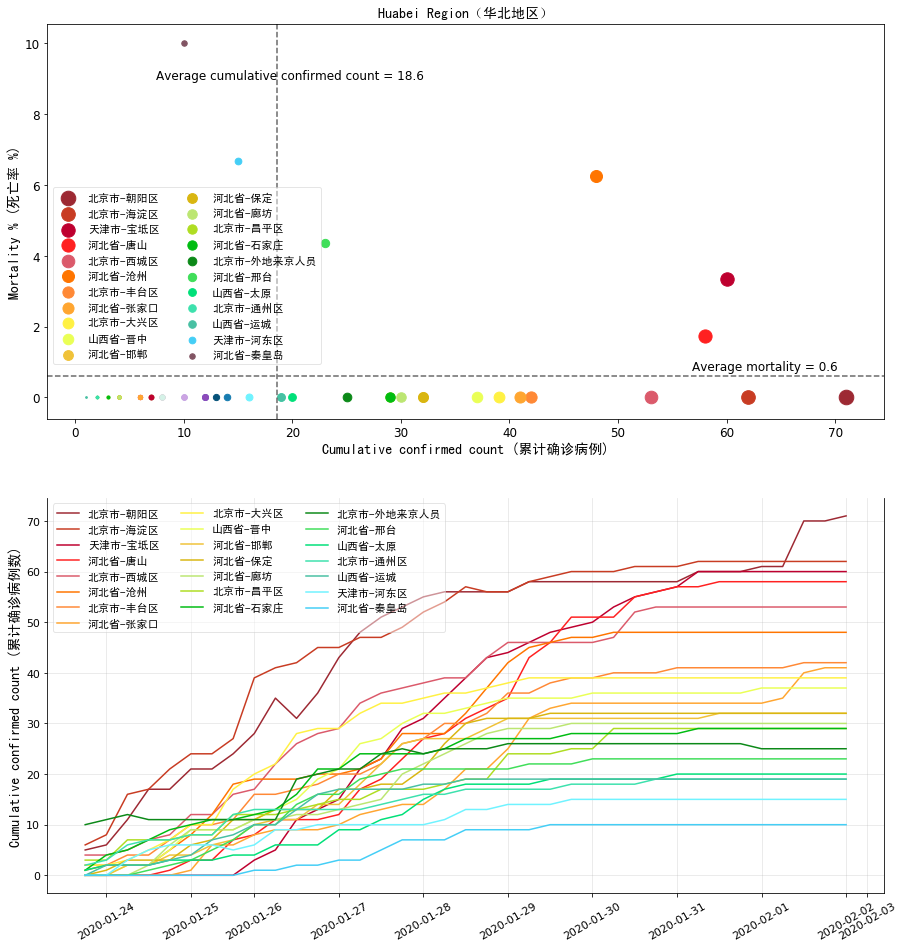

In [65]:
huabei_last_df, huabei_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                              provinceCity_daily_last_df,
                                                              title='Huabei Region（华北地区）',
                                                              region='华北地区',
                                                              loc=2,
                                                              ncol=2,
                                                              bbox_to_anchor=(0, 0.6))

In [66]:
# huabei_daily_pvt.to_csv('huabei_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，华北地区累计确诊病例平均值为{{int(round(huabei_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{huabei_last_df.loc[huabei_last_df['city_confirmedCount'] == huabei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{huabei_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{huabei_last_df.loc[huabei_last_df['mortality_pct'] == huabei_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(huabei_last_df.mortality_pct.max(), 2)}}%。

需要特别注意的是天津市宝坻区和河北省唐山市，他们分别于2020年2月1日和1月28日才出现第一例确诊病例，却出现快速增长的现象，于2月21日达到华北地区确诊病例并列第三的情况。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

**东北地区（辽宁省、吉林省、黑龙江省、内蒙古自治区）**

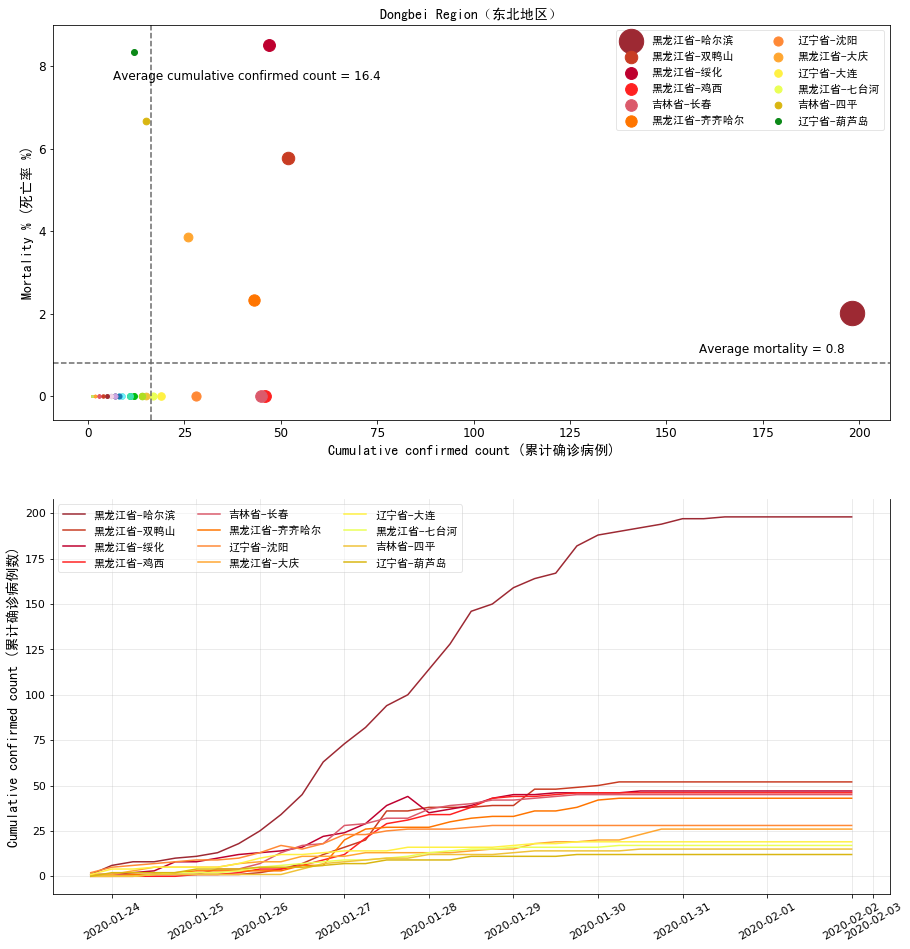

In [67]:
dongbei_last_df, dongbei_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                                provinceCity_daily_last_df,
                                                                title='Dongbei Region（东北地区）',
                                                                region='东北地区',
                                                                loc=1,
                                                                ncol=2,
                                                                bbox_to_anchor=(1, 1))

In [68]:
# dongbei_daily_pvt.to_csv('dongbei_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，东北地区累计确诊病例平均值为{{int(round(dongbei_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{dongbei_last_df.loc[dongbei_last_df['city_confirmedCount'] == dongbei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{dongbei_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{dongbei_last_df.loc[dongbei_last_df['mortality_pct'] == dongbei_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(dongbei_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

**华东地区（上海市、江苏省、浙江省、安徽省、福建省、江西省、山东省、台湾省）**

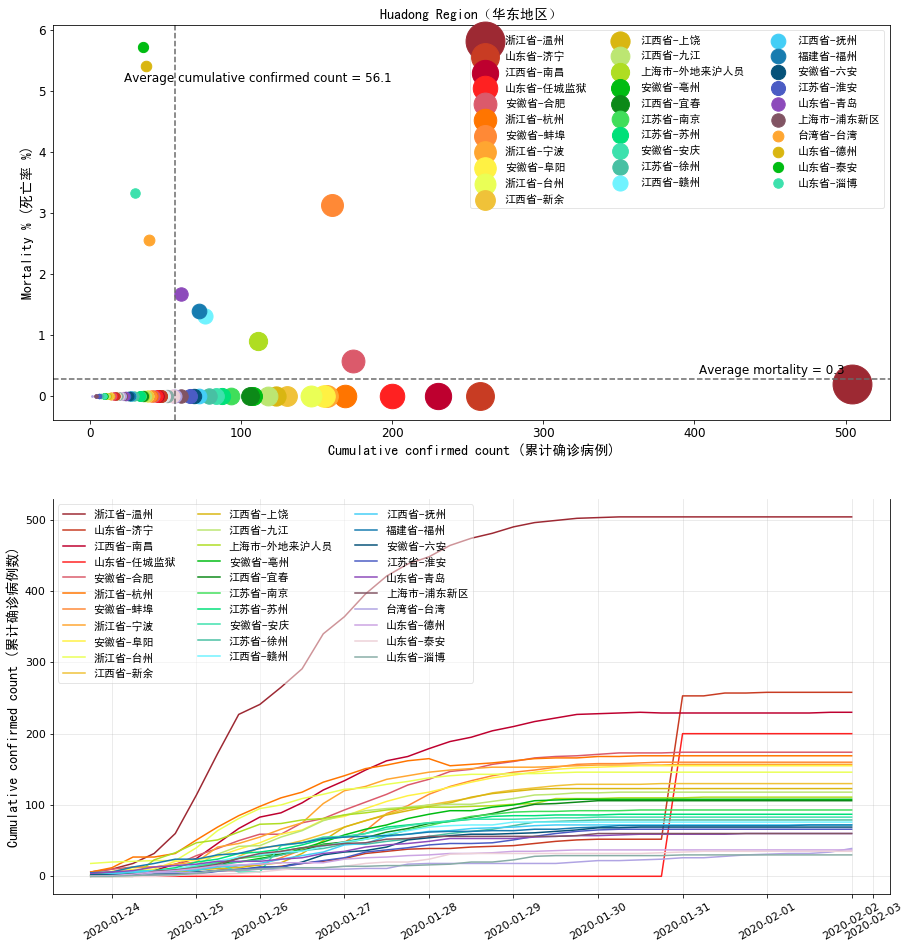

In [69]:
huadong_last_df, huadong_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                                provinceCity_daily_last_df,
                                                                title='Huadong Region（华东地区）',
                                                                region='华东地区',
                                                                loc=1,
                                                                ncol=3,
                                                                bbox_to_anchor=(1, 1))


In [70]:
# huadong_daily_pvt.to_csv('huadong_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，华东地区累计确诊病例平均值为{{int(round(huadong_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{huadong_last_df.loc[huadong_last_df['city_confirmedCount'] == huadong_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{huadong_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{huadong_last_df.loc[huadong_last_df['mortality_pct'] == huadong_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(huadong_last_df.mortality_pct.max(), 2)}}%。

需要特别注意的是山东省济宁和任城监狱确诊病例于2020年2月21日的大幅度增长来自于任城监狱确诊了200例病例。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

**中南地区（河南省、湖北省、湖南省、广东省、广西壮族自治区、海南省、香港特别行政区、澳门特别行政区）**

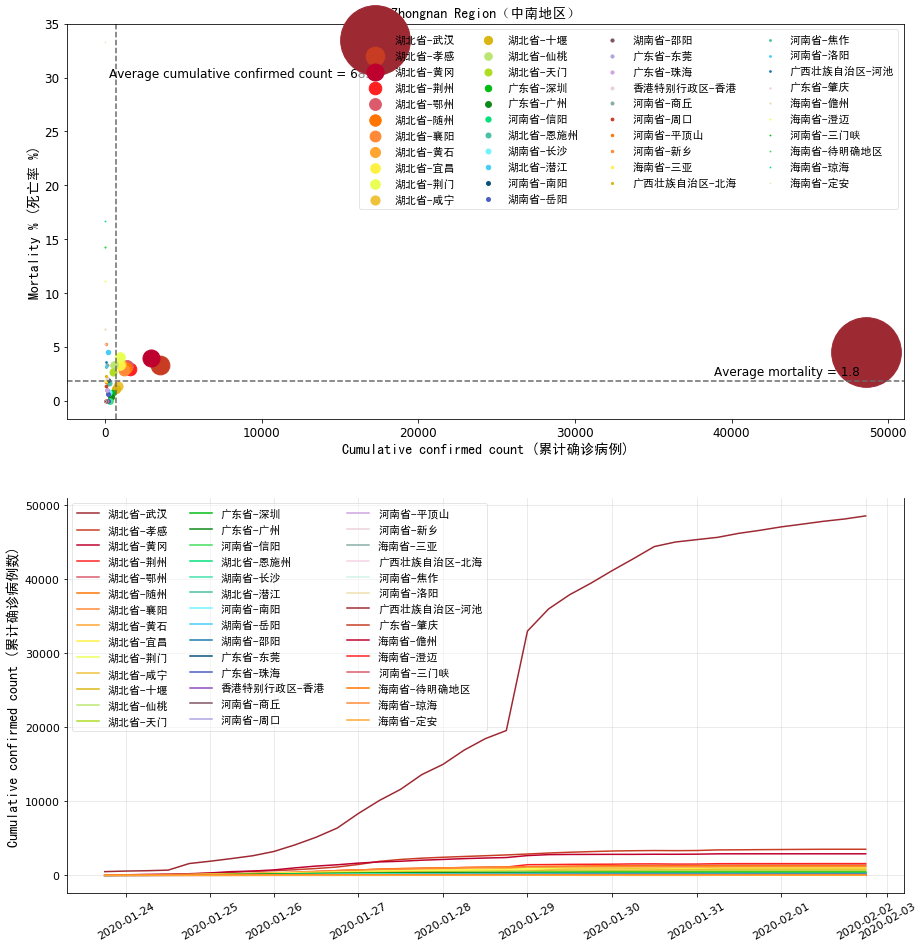

In [71]:
zhongnan_last_df, zhongnan_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                                  provinceCity_daily_last_df,
                                                                  title='Zhongnan Region（中南地区）',
                                                                  region='中南地区',
                                                                  loc=1,
                                                                  ncol=4,
                                                                  bbox_to_anchor=(1, 1),
                                                                  scale=0.1)

In [72]:
# zhongnan_daily_pvt.to_csv('zhongnan_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，中南地区累计确诊病例平均值为{{int(round(zhongnan_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{zhongnan_last_df.loc[zhongnan_last_df['city_confirmedCount'] == zhongnan_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{zhongnan_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{zhongnan_last_df.loc[zhongnan_last_df['mortality_pct'] == zhongnan_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(zhongnan_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

**西南地区（四川省、贵州省、云南省、重庆市、西藏自治区）**

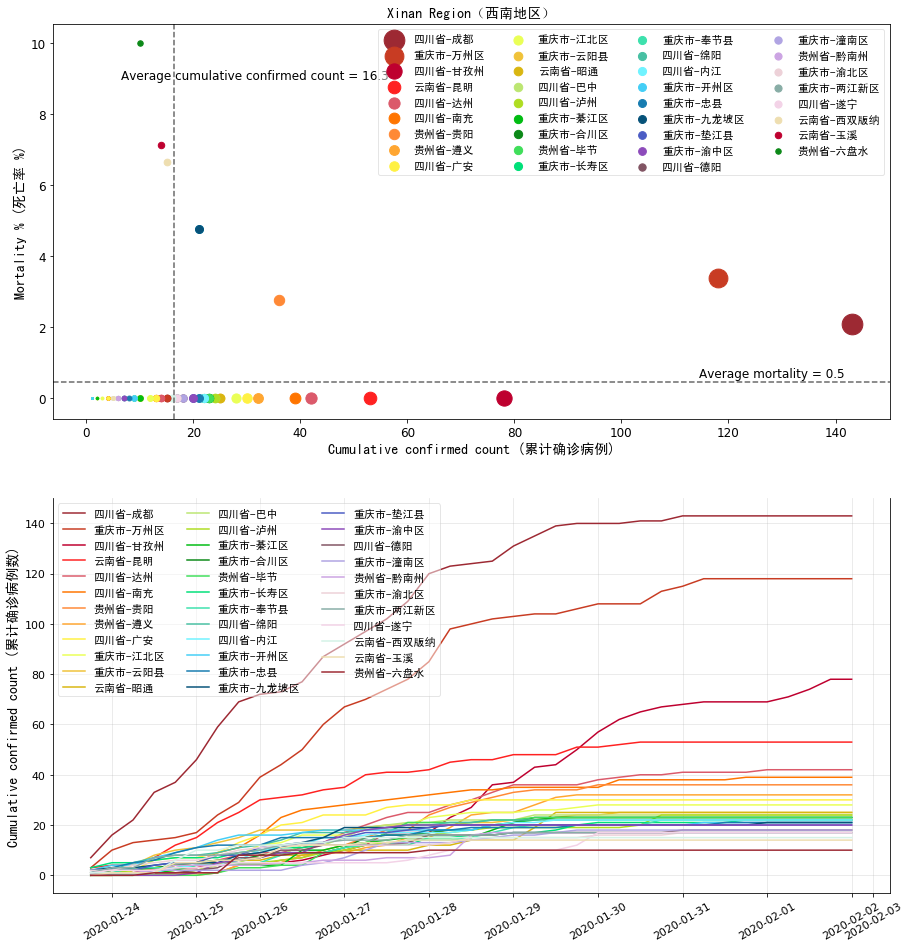

In [73]:
xinan_last_df, xinan_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                            provinceCity_daily_last_df,
                                                            title='Xinan Region（西南地区）',
                                                            region='西南地区',
                                                            loc=1,
                                                            ncol=4,
                                                            bbox_to_anchor=(1, 1))


In [74]:
# xinan_daily_pvt.to_csv('xinan_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，西南地区累计确诊病例平均值为{{int(round(xinan_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{xinan_last_df.loc[xinan_last_df['city_confirmedCount'] == xinan_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{xinan_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{xinan_last_df.loc[xinan_last_df['mortality_pct'] == xinan_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(xinan_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

**西北地区（陕西省、甘肃省、青海省、宁夏回族自治区、新疆维吾尔自治区）**

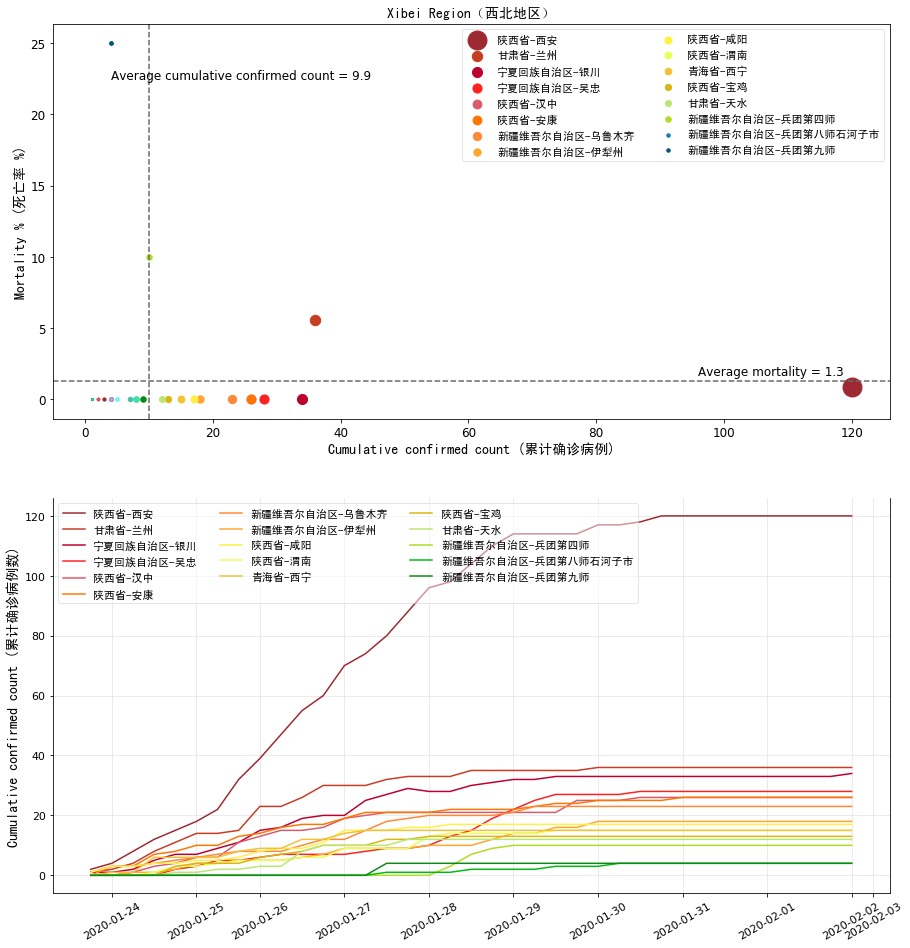

In [75]:
xibei_last_df, xibei_daily_pvt = region_scatter_line_charts(provinceCity_last_df,
                                                            provinceCity_daily_last_df,
                                                            title='Xibei Region（西北地区）',
                                                            region='西北地区',
                                                            loc=1,
                                                            ncol=2,
                                                            bbox_to_anchor=(1, 1))

In [76]:
# xibei_daily_pvt.to_csv('xibei_daily_pvt.csv')

截至北京时间{{not_hubei_daily_df.index[-1].year}}年{{not_hubei_daily_df.index[-1].month}}月{{not_hubei_daily_df.index[-1].day}}日24时，西北地区累计确诊病例平均值为{{int(round(xibei_last_df.city_confirmedCount.mean(), 0))}}例，累计确诊病例最多的城市（区）为{{xibei_last_df.loc[xibei_last_df['city_confirmedCount'] == xibei_last_df.city_confirmedCount.max(), 'pcName'].values[0]}}，共有{{xibei_last_df.city_confirmedCount.max()}}例。在累计确诊病例大于该地区平均值且死亡率为正的城市（区）中，{{xibei_last_df.loc[xibei_last_df['mortality_pct'] == xibei_last_df.mortality_pct.max(), 'pcName'].values[0]}}死亡率最高，为{{round(xibei_last_df.mortality_pct.max(), 2)}}%。

_注：上图只对累计确诊病例大于该地区平均值且死亡率为正的城市（区）进行了标注。_

## World

In [77]:
world_data_df = pd.read_csv('DXY_Country.csv')
world_data_df['updateTime'] = world_data_df.updateTime.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))
world_data_df['Date_ymd'] = world_data_df['updateTime'].apply(lambda d: d.date())
world_data_df['Time_hms'] = world_data_df['updateTime'].apply(lambda d: d.time())

In [78]:
# Daily confirmed count per country (complet missing dates)
country_daily_cfirmed_pvt = pd.pivot_table(
    data=world_data_df,
    index='Date_ymd',
    columns='countryName',
    values='confirmedCount',
    fill_value=0)
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.reset_index()

for i, v in country_daily_cfirmed_pvt.iterrows():
    for col in country_daily_cfirmed_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            country_daily_cfirmed_pvt.loc[i, col] = country_daily_cfirmed_pvt.loc[i-1, col]

country_daily_cfirmed_pvt.index = country_daily_cfirmed_pvt.Date_ymd

country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.stack()
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt.to_frame().reset_index()
country_daily_cfirmed_pvt = country_daily_cfirmed_pvt[
    country_daily_cfirmed_pvt['countryName'] != 'Date_ymd'].reset_index(drop=True)

country_daily_cfirmed_pvt.columns = ['Date_ymd', 'countryName', 'country_confirmedCount']

In [79]:
# Daily cured count per country (complet missing dates)
country_daily_cured_pvt = pd.pivot_table(
    data=world_data_df,
    index='Date_ymd',
    columns='countryName',
    values='curedCount',
    fill_value=0)
country_daily_cured_pvt = country_daily_cured_pvt.reset_index()

for i, v in country_daily_cured_pvt.iterrows():
    for col in country_daily_cured_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            country_daily_cured_pvt.loc[i, col] = country_daily_cured_pvt.loc[i-1, col]

country_daily_cured_pvt.index = country_daily_cured_pvt.Date_ymd

country_daily_cured_pvt = country_daily_cured_pvt.stack()
country_daily_cured_pvt = country_daily_cured_pvt.to_frame().reset_index()
country_daily_cured_pvt = country_daily_cured_pvt[
    country_daily_cured_pvt['countryName'] != 'Date_ymd'].reset_index(drop=True)

country_daily_cured_pvt.columns = ['Date_ymd', 'countryName', 'country_curedCount']

In [80]:
# Daily dead count per country (complet missing dates)
country_daily_dead_pvt = pd.pivot_table(
    data=world_data_df,
    index='Date_ymd',
    columns='countryName',
    values='deadCount',
    fill_value=0)
country_daily_dead_pvt = country_daily_dead_pvt.reset_index()

for i, v in country_daily_dead_pvt.iterrows():
    for col in country_daily_dead_pvt.columns[1:]:
        if i > 0 and v[col] == 0:
            country_daily_dead_pvt.loc[i, col] = country_daily_dead_pvt.loc[i-1, col]

country_daily_dead_pvt.index = country_daily_dead_pvt.Date_ymd

country_daily_dead_pvt = country_daily_dead_pvt.stack()
country_daily_dead_pvt = country_daily_dead_pvt.to_frame().reset_index()
country_daily_dead_pvt = country_daily_dead_pvt[
    country_daily_dead_pvt['countryName'] != 'Date_ymd'].reset_index(drop=True)

country_daily_dead_pvt.columns = ['Date_ymd', 'countryName', 'country_deadCount']

In [81]:
country_daily_df = pd.merge(country_daily_cfirmed_pvt,
                            country_daily_cured_pvt,
                            on=['Date_ymd', 'countryName'])
country_daily_df = pd.merge(country_daily_df,
                            country_daily_dead_pvt,
                            on=['Date_ymd', 'countryName'])

In [82]:
country_daily_df.index = country_daily_df['Date_ymd']

country_daily_df['mortality_pct'] = country_daily_df.apply(lambda row:calcul_percentage(
    row['country_deadCount'], row['country_confirmedCount']), axis='columns')

country_daily_df['cured_pct'] = country_daily_df.apply(lambda row:calcul_percentage(
    row['country_curedCount'], row['country_confirmedCount']), axis='columns')

country_daily_df['country_confirmedCount_new'] = country_daily_df['country_confirmedCount'].diff()
country_daily_df['country_confirmedCount_deltaRate'] = \
country_daily_df['country_confirmedCount_new'].pct_change() * 100
country_daily_df['country_act_confirmedCount'] = \
country_daily_df['country_confirmedCount'] - country_daily_df['country_curedCount'] - country_daily_df['country_deadCount']
country_daily_df = country_daily_df.fillna(0)
country_daily_df = country_daily_df.drop(columns='Date_ymd')

In [83]:
country_daily_df.head()

countryName  country_confirmedCount  country_curedCount  \
Date_ymd                                                              
2020-01-24  Afghanistan                     0.0                 0.0   
2020-01-24      Algeria                     0.0                 0.0   
2020-01-24    Australia                     0.0                 0.0   
2020-01-24      Austria                     0.0                 0.0   
2020-01-24   Azerbaijan                     0.0                 0.0   

            country_deadCount  mortality_pct  cured_pct  \
Date_ymd                                                  
2020-01-24                0.0            0.0        0.0   
2020-01-24                0.0            0.0        0.0   
2020-01-24                0.0            0.0        0.0   
2020-01-24                0.0            0.0        0.0   
2020-01-24                0.0            0.0        0.0   

            country_confirmedCount_new  country_confirmedCount_deltaRate  \
Date_ymd                                                                   
2020-01-24                         0.0                               0.0   
2020-01-24                         0.0                               0.0   
2020-01-24                         0.0                               0.0   
2020-01-24                         0.0                               0.0   
2020-01-24                         0.0                               0.0   

            country_act_confirmedCount  
Date_ymd                                
2020-01-24                         0.0  
2020-01-24                         0.0  
2020-01-24                         0.0  
2020-01-24                         0.0  
2020-01-24                         0.0

In [ ]:
china_daily_last.insert(loc=0, column='countryName', value='China') 

In [ ]:
china_daily_last.head(20)

In [ ]:
china_daily_last.index[0]

In [ ]:
country_daily_df.index[0]